# Q3

In [20]:
!pip install torchmetrics

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 8.5 MB/s eta 0:00:00a 0:00:01


In [21]:
from __future__ import division,print_function

%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
from tqdm import tqdm_notebook as tqdm

import random
import matplotlib.pyplot as plt
import math

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.autograd import Variable, grad
from torchvision import datasets, transforms
from torch.nn.parameter import Parameter
import torchvision
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,Dataset
from PIL import Image
import torchmetrics

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Hyper Parameters

In [4]:
### SETTINGS
# Hyperparameters
RANDOM_SEED = 123
LEARNING_RATE = 0.0005
batch_size = 128
NUM_EPOCHS = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Model

In [5]:
class ResNet18(nn.Module):
    def __init__(
        self, in_channels=3, out_channels=10, metric = False# , pretrained=False, embedding_reduction=False
    ):
        super(ResNet18, self).__init__()

        self.resnet = torchvision.models.resnet18(pretrained=False)
        self.resnet.conv1 = nn.Conv2d( in_channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False,)

        self.resnet.fc = nn.Linear( in_features=512, out_features=out_channels, bias=True)
        self.backbone = nn.Sequential(*list(self.resnet.children())[:-1])
        self.linear = nn.Sequential(self.resnet.fc)

        self.metric = metric
        self.fc_dimred = nn.Sequential(nn.Linear(in_features=512, out_features=128),)

    def forward(self, x): # flag for geting embedding,if True returns embedding
        x = self.backbone(x)
        x = torch.flatten(x, start_dim=1)

        if self.metric:

          x = x = self.fc_dimred(x)
          x = torch.nn.functional.normalize(x)
          return x
          
        else:
          x = self.linear(x)
          return x

## Data and Dataset

In [6]:
t = transforms.Compose([  transforms.RandomCrop(32, padding=4),
                          transforms.RandomHorizontalFlip(),
                          transforms.ToTensor(),
                          transforms.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233,0.24348505,0.26158768))]
                       )

In [7]:
data = datasets.CIFAR10('data', train=True, download=True)
data_test = datasets.CIFAR10('data', train=False, download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [8]:
X_train, X_val, y_train, y_val = train_test_split(data.data, data.targets, test_size = 0.2, stratify = data.targets)

In [9]:
batch_size = 64
X_test = data_test.data
y_test = data_test.targets

In [10]:
class MyDataset(Dataset):
    def __init__(self, X , y, transform):
       
        self.imgs = X
        self.labels = y
        self.transform = transform


    def __getitem__(self, idx):

        image = self.imgs[idx]
        image = Image.fromarray(image)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        
        #image = image.permute(2,0,1)

        #sample = {'image': image, 'label': label}
        return image, label

    def __len__(self):
        return len(self.labels)

In [11]:
class FilteredDataset(Dataset):
    def __init__(self, dataset, deleted_labels):
        self.dataset = dataset
        self.indices = [i for i, (_, target) in enumerate(self.dataset) if target not in deleted_labels]
        
    def __getitem__(self, index):
        return self.dataset[self.indices[index]]
    
    def __len__(self):
        return len(self.indices)

In [12]:
dataset_val = MyDataset(X_val, y_val, t)
dataset_train = MyDataset(X_train, y_train, t)
dataset_test = MyDataset(X_test, y_test,t)

## Part A

In [13]:
filtered_dataset_train_forg = FilteredDataset(dataset_train, [6]) # 6 == frog class
filtered_dataset_val_forg = FilteredDataset(dataset_val, [6])
filtered_dataset_test_forg = FilteredDataset(dataset_test, [6])

In [47]:
dataset_test_frog = FilteredDataset(dataset_test, [1,2,3,4,5,7,8,9])

In [15]:
train_loader = DataLoader(filtered_dataset_train_forg,
                          batch_size = batch_size,
                          shuffle = True,
                          num_workers = 4)
val_loader = DataLoader(filtered_dataset_val_forg,
                        batch_size = batch_size,
                        shuffle = False,
                        num_workers = 4)
test_loader = DataLoader(filtered_dataset_test_forg,
                        batch_size = batch_size,
                        shuffle = False,
                        num_workers = 4)

In [16]:
model1 = ResNet18(3,10, False)
model1.to(device)

ResNet18(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model1.parameters(), lr=LEARNING_RATE, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9, verbose=True)
epochs = 200
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)

Adjusting learning rate of group 0 to 5.0000e-04.


## Train and Inference

In [23]:
def train(model, train_loader, val_loader, acc = True):
  loss_train = []
  loss_val = []
  acc_train = []
  acc_val = []


  for epoch in range(epochs):

      model.train()

      total_loss = 0
      total_acc = 0

      for inputs, labels in train_loader:

          inputs, labels = inputs.to(device), labels.to(device)

          outputs = model(inputs.float())
          
          
          loss = criterion(outputs, labels)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          total_loss += loss.item()
          
          if acc:
              with torch.no_grad():
                  total_acc += accuracy(torch.argmax(outputs,1), labels).item()
      
      loss_train.append(total_loss/len(train_loader))
      acc_train.append(total_acc/len(train_loader))
      
      model.eval()

      total_loss = 0
      total_acc = 0

      with torch.no_grad():

          for inputs, labels in tqdm(val_loader,leave=False):

              inputs, labels = inputs.to(device),labels.to(device)
              outputs = model(inputs.float())
              loss = criterion(outputs, labels)
              total_loss += loss.item()
              if acc:
                  total_acc +=accuracy(torch.argmax(outputs,1),labels).item()


          loss_val.append(total_loss/len(val_loader))
          acc_val.append(total_acc/len(val_loader))

          print(f" epoch{epoch+1}: train_loss-> {loss_train[-1]}, val_loss-> {loss_val[-1]}, train accuracy -> {acc_train[-1]}, val_accuracy -> {acc_val[-1]}")
          scheduler.step()
  return model, loss_train, loss_val, acc_train, acc_val

In [169]:
model1, loss_train1, loss_val1, acc_train1, acc_val1 = train(model1, train_loader, val_loader)

  0%|          | 0/141 [00:00<?, ?it/s]

 epoch1: train_loss-> 0.2969162585230323, val_loss-> 0.6296416396367635, train accuracy -> 0.8920959147424512, val_accuracy -> 0.7979166668357579
Adjusting learning rate of group 0 to 3.1748e-13.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch2: train_loss-> 0.2990042456354595, val_loss-> 0.6150500788122204, train accuracy -> 0.8912910746003553, val_accuracy -> 0.7980939716312057
Adjusting learning rate of group 0 to 2.8573e-13.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch3: train_loss-> 0.29791622586402755, val_loss-> 0.6137722521386249, train accuracy -> 0.8937611012433393, val_accuracy -> 0.8002437944953323
Adjusting learning rate of group 0 to 2.5716e-13.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch4: train_loss-> 0.30046927437953797, val_loss-> 0.6357231884137958, train accuracy -> 0.8927619893428064, val_accuracy -> 0.795035461161999
Adjusting learning rate of group 0 to 2.3144e-13.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch5: train_loss-> 0.29103137170283877, val_loss-> 0.6177404130815615, train accuracy -> 0.8946214476021315, val_accuracy -> 0.7998670212765957
Adjusting learning rate of group 0 to 2.0830e-13.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch6: train_loss-> 0.29889371029066575, val_loss-> 0.620507835496402, train accuracy -> 0.8919293960923623, val_accuracy -> 0.7988696808510638
Adjusting learning rate of group 0 to 1.8747e-13.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch7: train_loss-> 0.2954572694472056, val_loss-> 0.6309537958380178, train accuracy -> 0.8917351243339254, val_accuracy -> 0.7983599292471054
Adjusting learning rate of group 0 to 1.6872e-13.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch8: train_loss-> 0.2970344011885235, val_loss-> 0.6303865007052185, train accuracy -> 0.8929285079928952, val_accuracy -> 0.7933732271194458
Adjusting learning rate of group 0 to 1.5185e-13.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch9: train_loss-> 0.30263026434511314, val_loss-> 0.614870900803424, train accuracy -> 0.891041296625222, val_accuracy -> 0.8000443260720436
Adjusting learning rate of group 0 to 1.3666e-13.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch10: train_loss-> 0.2989160841989263, val_loss-> 0.5944468134895284, train accuracy -> 0.8918183836589698, val_accuracy -> 0.8029476949509154
Adjusting learning rate of group 0 to 1.2300e-13.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch11: train_loss-> 0.3008856629526001, val_loss-> 0.6333444061431479, train accuracy -> 0.8921791740674956, val_accuracy -> 0.7951906027523339
Adjusting learning rate of group 0 to 1.1070e-13.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch12: train_loss-> 0.2963375070961076, val_loss-> 0.6051708417581328, train accuracy -> 0.8917351243339254, val_accuracy -> 0.8034574469776018
Adjusting learning rate of group 0 to 9.9628e-14.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch13: train_loss-> 0.2971827919937366, val_loss-> 0.6153974963206772, train accuracy -> 0.8933448046181173, val_accuracy -> 0.7973847516039585
Adjusting learning rate of group 0 to 8.9665e-14.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch14: train_loss-> 0.2997683957616135, val_loss-> 0.6198939450666414, train accuracy -> 0.8928730017761989, val_accuracy -> 0.7973404256164605
Adjusting learning rate of group 0 to 8.0699e-14.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch15: train_loss-> 0.30043005887716745, val_loss-> 0.6097917370762386, train accuracy -> 0.8913743339253997, val_accuracy -> 0.803302304964539
Adjusting learning rate of group 0 to 7.2629e-14.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch16: train_loss-> 0.2978677687700011, val_loss-> 0.6178639070362064, train accuracy -> 0.8912633214920072, val_accuracy -> 0.797805851232921
Adjusting learning rate of group 0 to 6.5366e-14.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch17: train_loss-> 0.2997271939185754, val_loss-> 0.6069519418351194, train accuracy -> 0.8925399644760214, val_accuracy -> 0.797761524822695
Adjusting learning rate of group 0 to 5.8829e-14.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch18: train_loss-> 0.30116465434987844, val_loss-> 0.6107601066853138, train accuracy -> 0.8904862344582594, val_accuracy -> 0.8006870569066799
Adjusting learning rate of group 0 to 5.2946e-14.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch19: train_loss-> 0.2974594147813045, val_loss-> 0.6128387873899852, train accuracy -> 0.8930672735346359, val_accuracy -> 0.7985815604527792
Adjusting learning rate of group 0 to 4.7652e-14.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch20: train_loss-> 0.30041142964659534, val_loss-> 0.6127959472913269, train accuracy -> 0.8919293960923623, val_accuracy -> 0.8027925533605805
Adjusting learning rate of group 0 to 4.2887e-14.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch21: train_loss-> 0.2982767156025868, val_loss-> 0.6158096348562985, train accuracy -> 0.8916796181172292, val_accuracy -> 0.8017065601145967
Adjusting learning rate of group 0 to 3.8598e-14.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch22: train_loss-> 0.299552699865287, val_loss-> 0.6072645060559536, train accuracy -> 0.8921236678507993, val_accuracy -> 0.8002881204828303
Adjusting learning rate of group 0 to 3.4738e-14.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch23: train_loss-> 0.3015533185846852, val_loss-> 0.6176788964381454, train accuracy -> 0.8921791740674956, val_accuracy -> 0.7986037232351642
Adjusting learning rate of group 0 to 3.1264e-14.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch24: train_loss-> 0.2980012860063126, val_loss-> 0.5994420611689276, train accuracy -> 0.8921791740674956, val_accuracy -> 0.8003324468930563
Adjusting learning rate of group 0 to 2.8138e-14.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch25: train_loss-> 0.29982567151105216, val_loss-> 0.6031910473784656, train accuracy -> 0.8931505328596803, val_accuracy -> 0.8037012409656605
Adjusting learning rate of group 0 to 2.5324e-14.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch26: train_loss-> 0.298127955537071, val_loss-> 0.6224208207840615, train accuracy -> 0.8914853463587922, val_accuracy -> 0.7972739360011216
Adjusting learning rate of group 0 to 2.2792e-14.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch27: train_loss-> 0.29674851059331353, val_loss-> 0.6047610064558949, train accuracy -> 0.8929840142095915, val_accuracy -> 0.8030585105537523
Adjusting learning rate of group 0 to 2.0513e-14.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch28: train_loss-> 0.3016658650701253, val_loss-> 0.6084674966673479, train accuracy -> 0.8921236678507993, val_accuracy -> 0.7995567376731981
Adjusting learning rate of group 0 to 1.8461e-14.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch29: train_loss-> 0.2976365761821477, val_loss-> 0.6192654717898538, train accuracy -> 0.8913188277087034, val_accuracy -> 0.8003546100981692
Adjusting learning rate of group 0 to 1.6615e-14.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch30: train_loss-> 0.29955960200110293, val_loss-> 0.6168839098713922, train accuracy -> 0.8920404085257548, val_accuracy -> 0.8006427304964538
Adjusting learning rate of group 0 to 1.4954e-14.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch31: train_loss-> 0.2986261339901184, val_loss-> 0.6105776337232995, train accuracy -> 0.8928730017761989, val_accuracy -> 0.799689716481148
Adjusting learning rate of group 0 to 1.3458e-14.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch32: train_loss-> 0.29841469126368075, val_loss-> 0.6069348090929343, train accuracy -> 0.89226243339254, val_accuracy -> 0.799645390070922
Adjusting learning rate of group 0 to 1.2112e-14.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch33: train_loss-> 0.2944783896446016, val_loss-> 0.6221089236279751, train accuracy -> 0.8920959147424512, val_accuracy -> 0.801396276511199
Adjusting learning rate of group 0 to 1.0901e-14.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch34: train_loss-> 0.30078670164143423, val_loss-> 0.6075157366745861, train accuracy -> 0.8911523090586145, val_accuracy -> 0.8020168441407224
Adjusting learning rate of group 0 to 9.8111e-15.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch35: train_loss-> 0.29724878130966986, val_loss-> 0.6143943697002763, train accuracy -> 0.8931782859680284, val_accuracy -> 0.7992464540698004
Adjusting learning rate of group 0 to 8.8300e-15.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch36: train_loss-> 0.3035282303395534, val_loss-> 0.6172550500284696, train accuracy -> 0.8899311722912966, val_accuracy -> 0.7993351064675244
Adjusting learning rate of group 0 to 7.9470e-15.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch37: train_loss-> 0.2948073506434688, val_loss-> 0.6294247059957355, train accuracy -> 0.8936223357015985, val_accuracy -> 0.7970523047954479
Adjusting learning rate of group 0 to 7.1523e-15.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch38: train_loss-> 0.2973437736978751, val_loss-> 0.6063027591147321, train accuracy -> 0.8924011989342806, val_accuracy -> 0.8030585105537523
Adjusting learning rate of group 0 to 6.4371e-15.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch39: train_loss-> 0.2981069095128383, val_loss-> 0.6170136226829908, train accuracy -> 0.8923456927175843, val_accuracy -> 0.7984042552346033
Adjusting learning rate of group 0 to 5.7933e-15.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch40: train_loss-> 0.29427727421689415, val_loss-> 0.6181414209781809, train accuracy -> 0.8949822380106572, val_accuracy -> 0.796875
Adjusting learning rate of group 0 to 5.2140e-15.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch41: train_loss-> 0.29677942743256924, val_loss-> 0.5912448187880482, train accuracy -> 0.8926232238010657, val_accuracy -> 0.8029033689634174
Adjusting learning rate of group 0 to 4.6926e-15.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch42: train_loss-> 0.29384274932937976, val_loss-> 0.620022622194696, train accuracy -> 0.8932615452930728, val_accuracy -> 0.7971187944107867
Adjusting learning rate of group 0 to 4.2234e-15.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch43: train_loss-> 0.2956846088409212, val_loss-> 0.6078856870637718, train accuracy -> 0.8942051509769094, val_accuracy -> 0.8025709221549068
Adjusting learning rate of group 0 to 3.8010e-15.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch44: train_loss-> 0.29844341600449426, val_loss-> 0.6144512874860291, train accuracy -> 0.8930117673179396, val_accuracy -> 0.7967641843971631
Adjusting learning rate of group 0 to 3.4209e-15.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch45: train_loss-> 0.2980458900517723, val_loss-> 0.6143382642920135, train accuracy -> 0.8929840142095915, val_accuracy -> 0.7984485816448292
Adjusting learning rate of group 0 to 3.0788e-15.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch46: train_loss-> 0.29372300987080613, val_loss-> 0.6120225894958415, train accuracy -> 0.8942606571936057, val_accuracy -> 0.7982269504391555
Adjusting learning rate of group 0 to 2.7709e-15.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch47: train_loss-> 0.29980300075736815, val_loss-> 0.6125345464716566, train accuracy -> 0.892678730017762, val_accuracy -> 0.796875
Adjusting learning rate of group 0 to 2.4938e-15.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch48: train_loss-> 0.3027592694542336, val_loss-> 0.6068334933502454, train accuracy -> 0.8923179396092362, val_accuracy -> 0.8027482269503546
Adjusting learning rate of group 0 to 2.2445e-15.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch49: train_loss-> 0.2969991857745084, val_loss-> 0.618997927253128, train accuracy -> 0.8930672735346359, val_accuracy -> 0.7969858156028369
Adjusting learning rate of group 0 to 2.0200e-15.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch50: train_loss-> 0.3006063221323554, val_loss-> 0.623126172744636, train accuracy -> 0.8921514209591475, val_accuracy -> 0.795057623944384
Adjusting learning rate of group 0 to 1.8180e-15.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch51: train_loss-> 0.30017259084416115, val_loss-> 0.6163267583077681, train accuracy -> 0.8920126554174067, val_accuracy -> 0.7998226948663698
Adjusting learning rate of group 0 to 1.6362e-15.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch52: train_loss-> 0.3022880792009047, val_loss-> 0.6268690340485134, train accuracy -> 0.8905139875666075, val_accuracy -> 0.7985150708374402
Adjusting learning rate of group 0 to 1.4726e-15.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch53: train_loss-> 0.29856606759461796, val_loss-> 0.6191394252980009, train accuracy -> 0.8920681616341031, val_accuracy -> 0.7958776595744681
Adjusting learning rate of group 0 to 1.3253e-15.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch54: train_loss-> 0.29429269608500586, val_loss-> 0.6088858737167737, train accuracy -> 0.8936500888099467, val_accuracy -> 0.8034352837724889
Adjusting learning rate of group 0 to 1.1928e-15.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch55: train_loss-> 0.3015470779757305, val_loss-> 0.603774127702341, train accuracy -> 0.8920126554174067, val_accuracy -> 0.7965868796017153
Adjusting learning rate of group 0 to 1.0735e-15.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch56: train_loss-> 0.2947706022361032, val_loss-> 0.6103723594482909, train accuracy -> 0.8934835701598579, val_accuracy -> 0.8024601065520699
Adjusting learning rate of group 0 to 9.6617e-16.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch57: train_loss-> 0.29676100114099085, val_loss-> 0.6184210501452709, train accuracy -> 0.8938443605683837, val_accuracy -> 0.8020833333333334
Adjusting learning rate of group 0 to 8.6955e-16.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch58: train_loss-> 0.30311055915499663, val_loss-> 0.6140021125898294, train accuracy -> 0.8903474689165186, val_accuracy -> 0.8024822693344549
Adjusting learning rate of group 0 to 7.8260e-16.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch59: train_loss-> 0.30165650555285, val_loss-> 0.6246833055154651, train accuracy -> 0.8924567051509769, val_accuracy -> 0.7933067375041069
Adjusting learning rate of group 0 to 7.0434e-16.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch60: train_loss-> 0.29815403217214886, val_loss-> 0.6049522019869892, train accuracy -> 0.8933170515097691, val_accuracy -> 0.8007978725095167
Adjusting learning rate of group 0 to 6.3390e-16.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch61: train_loss-> 0.2971989949288419, val_loss-> 0.6181881681401679, train accuracy -> 0.8942329040852576, val_accuracy -> 0.8034574469776018
Adjusting learning rate of group 0 to 5.7051e-16.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch62: train_loss-> 0.2974881986900502, val_loss-> 0.5989173138183905, train accuracy -> 0.8930395204262878, val_accuracy -> 0.8039893617866732
Adjusting learning rate of group 0 to 5.1346e-16.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch63: train_loss-> 0.29583273523654224, val_loss-> 0.6153659002578005, train accuracy -> 0.8948989786856127, val_accuracy -> 0.7992464540698004
Adjusting learning rate of group 0 to 4.6211e-16.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch64: train_loss-> 0.29424499748125804, val_loss-> 0.6161187622986787, train accuracy -> 0.8949267317939609, val_accuracy -> 0.7971631203982847
Adjusting learning rate of group 0 to 4.1590e-16.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch65: train_loss-> 0.2972722030633508, val_loss-> 0.6076703022980521, train accuracy -> 0.8950932504440497, val_accuracy -> 0.8001329788924955
Adjusting learning rate of group 0 to 3.7431e-16.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch66: train_loss-> 0.29611210847938463, val_loss-> 0.6310010616872328, train accuracy -> 0.8943716696269982, val_accuracy -> 0.7972960992062346
Adjusting learning rate of group 0 to 3.3688e-16.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch67: train_loss-> 0.2969839406823392, val_loss-> 0.6207850047037111, train accuracy -> 0.8945936944937833, val_accuracy -> 0.8011746453055253
Adjusting learning rate of group 0 to 3.0319e-16.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch68: train_loss-> 0.29417120056561, val_loss-> 0.6121341340930749, train accuracy -> 0.8955373001776199, val_accuracy -> 0.7998448580714828
Adjusting learning rate of group 0 to 2.7287e-16.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch69: train_loss-> 0.2990038616592677, val_loss-> 0.6136466962225894, train accuracy -> 0.8937888543516874, val_accuracy -> 0.8018838653327726
Adjusting learning rate of group 0 to 2.4559e-16.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch70: train_loss-> 0.3041068300551885, val_loss-> 0.6221720413536045, train accuracy -> 0.8906805062166963, val_accuracy -> 0.7982269504391555
Adjusting learning rate of group 0 to 2.2103e-16.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch71: train_loss-> 0.3027350645955672, val_loss-> 0.6119003741876453, train accuracy -> 0.8912078152753108, val_accuracy -> 0.800576241303843
Adjusting learning rate of group 0 to 1.9893e-16.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch72: train_loss-> 0.2987033034117353, val_loss-> 0.6059410953564002, train accuracy -> 0.8920959147424512, val_accuracy -> 0.8026595745526307
Adjusting learning rate of group 0 to 1.7903e-16.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch73: train_loss-> 0.2978088941762545, val_loss-> 0.6173824500953052, train accuracy -> 0.892678730017762, val_accuracy -> 0.8003324468930563
Adjusting learning rate of group 0 to 1.6113e-16.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch74: train_loss-> 0.2986089291835128, val_loss-> 0.6095279778571839, train accuracy -> 0.8925954706927176, val_accuracy -> 0.8044769501855188
Adjusting learning rate of group 0 to 1.4502e-16.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch75: train_loss-> 0.2995828520605873, val_loss-> 0.6061290413775342, train accuracy -> 0.8903197158081705, val_accuracy -> 0.7980718084260927
Adjusting learning rate of group 0 to 1.3051e-16.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch76: train_loss-> 0.3018739108611593, val_loss-> 0.6208705409621516, train accuracy -> 0.8908192717584369, val_accuracy -> 0.8021276597435593
Adjusting learning rate of group 0 to 1.1746e-16.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch77: train_loss-> 0.29618825758170486, val_loss-> 0.6142414191090468, train accuracy -> 0.8930672735346359, val_accuracy -> 0.7947916667512123
Adjusting learning rate of group 0 to 1.0572e-16.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch78: train_loss-> 0.30021033249464596, val_loss-> 0.6130789699072533, train accuracy -> 0.8920681616341031, val_accuracy -> 0.8004875884833911
Adjusting learning rate of group 0 to 9.5145e-17.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch79: train_loss-> 0.29863280746060195, val_loss-> 0.6178668380206358, train accuracy -> 0.8928730017761989, val_accuracy -> 0.798714538838001
Adjusting learning rate of group 0 to 8.5631e-17.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch80: train_loss-> 0.30265585310611587, val_loss-> 0.612269290372835, train accuracy -> 0.891457593250444, val_accuracy -> 0.7982491136442685
Adjusting learning rate of group 0 to 7.7068e-17.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch81: train_loss-> 0.29759477957633207, val_loss-> 0.6184868436333135, train accuracy -> 0.8927619893428064, val_accuracy -> 0.7961436171903677
Adjusting learning rate of group 0 to 6.9361e-17.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch82: train_loss-> 0.302489300207177, val_loss-> 0.6177056996112175, train accuracy -> 0.8913465808170515, val_accuracy -> 0.797828014015306
Adjusting learning rate of group 0 to 6.2425e-17.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch83: train_loss-> 0.3030369114229988, val_loss-> 0.614569883185921, train accuracy -> 0.8917351243339254, val_accuracy -> 0.7969858156028369
Adjusting learning rate of group 0 to 5.6182e-17.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch84: train_loss-> 0.29814421365676086, val_loss-> 0.6133942122155047, train accuracy -> 0.8930395204262878, val_accuracy -> 0.7935948583251196
Adjusting learning rate of group 0 to 5.0564e-17.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch85: train_loss-> 0.29584622620001144, val_loss-> 0.6145407925260827, train accuracy -> 0.8928174955595026, val_accuracy -> 0.8035017729650998
Adjusting learning rate of group 0 to 4.5508e-17.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch86: train_loss-> 0.299902896421629, val_loss-> 0.6160084634807939, train accuracy -> 0.8919849023090586, val_accuracy -> 0.7976950356300841
Adjusting learning rate of group 0 to 4.0957e-17.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch87: train_loss-> 0.29987928812552517, val_loss-> 0.6229582665659857, train accuracy -> 0.8900976909413855, val_accuracy -> 0.7966755319994392
Adjusting learning rate of group 0 to 3.6861e-17.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch88: train_loss-> 0.29985214666617277, val_loss-> 0.6146471639896961, train accuracy -> 0.8925954706927176, val_accuracy -> 0.7961879431778658
Adjusting learning rate of group 0 to 3.3175e-17.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch89: train_loss-> 0.2997017590391911, val_loss-> 0.6161369019789054, train accuracy -> 0.8927897424511545, val_accuracy -> 0.7985815604527792
Adjusting learning rate of group 0 to 2.9858e-17.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch90: train_loss-> 0.2951488698804569, val_loss-> 0.6123485106525691, train accuracy -> 0.8945936944937833, val_accuracy -> 0.7980939716312057
Adjusting learning rate of group 0 to 2.6872e-17.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch91: train_loss-> 0.2957234466531137, val_loss-> 0.6104654650738899, train accuracy -> 0.894316163410302, val_accuracy -> 0.7960106383824179
Adjusting learning rate of group 0 to 2.4185e-17.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch92: train_loss-> 0.29854510048301774, val_loss-> 0.6076057040733649, train accuracy -> 0.893511323268206, val_accuracy -> 0.8009751773049646
Adjusting learning rate of group 0 to 2.1766e-17.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch93: train_loss-> 0.3004674565569757, val_loss-> 0.6108285514175469, train accuracy -> 0.8915408525754884, val_accuracy -> 0.7991799644544615
Adjusting learning rate of group 0 to 1.9590e-17.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch94: train_loss-> 0.2988061403614166, val_loss-> 0.6107675633954663, train accuracy -> 0.89226243339254, val_accuracy -> 0.801529255319149
Adjusting learning rate of group 0 to 1.7631e-17.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch95: train_loss-> 0.30041030614403597, val_loss-> 0.6223489012278564, train accuracy -> 0.8912910746003553, val_accuracy -> 0.7945035459301996
Adjusting learning rate of group 0 to 1.5868e-17.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch96: train_loss-> 0.29803793619305796, val_loss-> 0.6132553524159371, train accuracy -> 0.8923179396092362, val_accuracy -> 0.8003102836879432
Adjusting learning rate of group 0 to 1.4281e-17.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch97: train_loss-> 0.3009934554515046, val_loss-> 0.6171275237773327, train accuracy -> 0.8924567051509769, val_accuracy -> 0.8009086881123536
Adjusting learning rate of group 0 to 1.2853e-17.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch98: train_loss-> 0.2966317912930917, val_loss-> 0.6137508209926862, train accuracy -> 0.8941218916518651, val_accuracy -> 0.8019946809356094
Adjusting learning rate of group 0 to 1.1567e-17.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch99: train_loss-> 0.2952245849037467, val_loss-> 0.6139410865222309, train accuracy -> 0.892678730017762, val_accuracy -> 0.7980718084260927
Adjusting learning rate of group 0 to 1.0411e-17.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch100: train_loss-> 0.3007693773873322, val_loss-> 0.6122335439666788, train accuracy -> 0.8924567051509769, val_accuracy -> 0.8023271277441201
Adjusting learning rate of group 0 to 9.3696e-18.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch101: train_loss-> 0.294883798179258, val_loss-> 0.6029397739586255, train accuracy -> 0.8941496447602132, val_accuracy -> 0.8046542554036945
Adjusting learning rate of group 0 to 8.4327e-18.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch102: train_loss-> 0.30269626128366534, val_loss-> 0.6101177121307833, train accuracy -> 0.8911245559502664, val_accuracy -> 0.7983377660419924
Adjusting learning rate of group 0 to 7.5894e-18.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch103: train_loss-> 0.29630556628505034, val_loss-> 0.609210101425225, train accuracy -> 0.8932892984014209, val_accuracy -> 0.7947030143534883
Adjusting learning rate of group 0 to 6.8305e-18.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch104: train_loss-> 0.29650120159237253, val_loss-> 0.6094016980194876, train accuracy -> 0.8934003108348135, val_accuracy -> 0.7982269504391555
Adjusting learning rate of group 0 to 6.1474e-18.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch105: train_loss-> 0.29602192503732644, val_loss-> 0.618357649297579, train accuracy -> 0.8934835701598579, val_accuracy -> 0.7979609928232558
Adjusting learning rate of group 0 to 5.5327e-18.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch106: train_loss-> 0.29754348292443933, val_loss-> 0.6269946065566219, train accuracy -> 0.8937611012433393, val_accuracy -> 0.7917553190643906
Adjusting learning rate of group 0 to 4.9794e-18.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch107: train_loss-> 0.2954448688358439, val_loss-> 0.6170368466182803, train accuracy -> 0.8937611012433393, val_accuracy -> 0.7983156028368794
Adjusting learning rate of group 0 to 4.4815e-18.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch108: train_loss-> 0.300568446225849, val_loss-> 0.6040453233406053, train accuracy -> 0.891457593250444, val_accuracy -> 0.8031914893617021
Adjusting learning rate of group 0 to 4.0333e-18.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch109: train_loss-> 0.2977405869489665, val_loss-> 0.6132993943302344, train accuracy -> 0.8932060390763765, val_accuracy -> 0.8000000000845456
Adjusting learning rate of group 0 to 3.6300e-18.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch110: train_loss-> 0.2949095928700737, val_loss-> 0.6075756710471837, train accuracy -> 0.8935945825932504, val_accuracy -> 0.7997783688788719
Adjusting learning rate of group 0 to 3.2670e-18.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch111: train_loss-> 0.2999086134519501, val_loss-> 0.625217412697508, train accuracy -> 0.891457593250444, val_accuracy -> 0.8001329788924955
Adjusting learning rate of group 0 to 2.9403e-18.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch112: train_loss-> 0.2987974890463094, val_loss-> 0.6212734443710205, train accuracy -> 0.8925399644760214, val_accuracy -> 0.7998670212765957
Adjusting learning rate of group 0 to 2.6463e-18.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch113: train_loss-> 0.2950871742957439, val_loss-> 0.6222247956915105, train accuracy -> 0.893511323268206, val_accuracy -> 0.7956338651636814
Adjusting learning rate of group 0 to 2.3816e-18.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch114: train_loss-> 0.2966769364386215, val_loss-> 0.6045192788678704, train accuracy -> 0.8943439165186501, val_accuracy -> 0.7960992907801419
Adjusting learning rate of group 0 to 2.1435e-18.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch115: train_loss-> 0.2999749883188871, val_loss-> 0.6164569903350046, train accuracy -> 0.8928730017761989, val_accuracy -> 0.796875
Adjusting learning rate of group 0 to 1.9291e-18.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch116: train_loss-> 0.29915457441211807, val_loss-> 0.6022461622107959, train accuracy -> 0.8901809502664298, val_accuracy -> 0.8006427304964538
Adjusting learning rate of group 0 to 1.7362e-18.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch117: train_loss-> 0.2986389168837566, val_loss-> 0.6185242946900374, train accuracy -> 0.8924289520426287, val_accuracy -> 0.8021054965384463
Adjusting learning rate of group 0 to 1.5626e-18.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch118: train_loss-> 0.29767211260634674, val_loss-> 0.6019530558417029, train accuracy -> 0.8925677175843695, val_accuracy -> 0.8062278370485239
Adjusting learning rate of group 0 to 1.4063e-18.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch119: train_loss-> 0.30216264823984296, val_loss-> 0.6131676024367624, train accuracy -> 0.8904029751332149, val_accuracy -> 0.7982269504391555
Adjusting learning rate of group 0 to 1.2657e-18.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch120: train_loss-> 0.2979142853781766, val_loss-> 0.6222461028724697, train accuracy -> 0.8912078152753108, val_accuracy -> 0.800576241303843
Adjusting learning rate of group 0 to 1.1391e-18.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch121: train_loss-> 0.29852336917740835, val_loss-> 0.604355180939884, train accuracy -> 0.8932337921847247, val_accuracy -> 0.8002659572777173
Adjusting learning rate of group 0 to 1.0252e-18.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch122: train_loss-> 0.29498921889236085, val_loss-> 0.6107300426943082, train accuracy -> 0.8940663854351687, val_accuracy -> 0.8025930849372918
Adjusting learning rate of group 0 to 9.2269e-19.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch123: train_loss-> 0.297436308982529, val_loss-> 0.6123518140603464, train accuracy -> 0.8923734458259325, val_accuracy -> 0.8016622341270988
Adjusting learning rate of group 0 to 8.3043e-19.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch124: train_loss-> 0.2980293557180181, val_loss-> 0.610218162232257, train accuracy -> 0.8929285079928952, val_accuracy -> 0.7988475176459509
Adjusting learning rate of group 0 to 7.4738e-19.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch125: train_loss-> 0.29782427107620835, val_loss-> 0.6108617373603455, train accuracy -> 0.8934558170515098, val_accuracy -> 0.7992907800572984
Adjusting learning rate of group 0 to 6.7264e-19.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch126: train_loss-> 0.29687607387613446, val_loss-> 0.6107978374822766, train accuracy -> 0.8932337921847247, val_accuracy -> 0.7993572696726373
Adjusting learning rate of group 0 to 6.0538e-19.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch127: train_loss-> 0.29785390543630663, val_loss-> 0.6098614943788406, train accuracy -> 0.8936778419182948, val_accuracy -> 0.8015514185242619
Adjusting learning rate of group 0 to 5.4484e-19.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch128: train_loss-> 0.29850491780794325, val_loss-> 0.6145275571244828, train accuracy -> 0.8940663854351687, val_accuracy -> 0.8018173757174336
Adjusting learning rate of group 0 to 4.9036e-19.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch129: train_loss-> 0.29812720224764166, val_loss-> 0.6093747625325588, train accuracy -> 0.8932337921847247, val_accuracy -> 0.8007535460992907
Adjusting learning rate of group 0 to 4.4132e-19.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch130: train_loss-> 0.2975307462032269, val_loss-> 0.6148700777520525, train accuracy -> 0.8924844582593251, val_accuracy -> 0.799645390070922
Adjusting learning rate of group 0 to 3.9719e-19.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch131: train_loss-> 0.3000596920243377, val_loss-> 0.5970789831369481, train accuracy -> 0.8906527531083481, val_accuracy -> 0.8024822693344549
Adjusting learning rate of group 0 to 3.5747e-19.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch132: train_loss-> 0.29993417558672164, val_loss-> 0.6134831978285566, train accuracy -> 0.8907082593250444, val_accuracy -> 0.8011968085106383
Adjusting learning rate of group 0 to 3.2172e-19.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch133: train_loss-> 0.2986460303487405, val_loss-> 0.6024187678563679, train accuracy -> 0.8916241119005328, val_accuracy -> 0.803390957362263
Adjusting learning rate of group 0 to 2.8955e-19.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch134: train_loss-> 0.2994716384879861, val_loss-> 0.6071033401692167, train accuracy -> 0.8917351243339254, val_accuracy -> 0.8027703901554676
Adjusting learning rate of group 0 to 2.6060e-19.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch135: train_loss-> 0.30217691966155497, val_loss-> 0.6005341195045634, train accuracy -> 0.8931782859680284, val_accuracy -> 0.804144503377008
Adjusting learning rate of group 0 to 2.3454e-19.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch136: train_loss-> 0.2959728234085266, val_loss-> 0.6068294982538156, train accuracy -> 0.8943994227353463, val_accuracy -> 0.8024822693344549
Adjusting learning rate of group 0 to 2.1108e-19.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch137: train_loss-> 0.30124830045666195, val_loss-> 0.6153817791888054, train accuracy -> 0.8921514209591475, val_accuracy -> 0.7989583332487877
Adjusting learning rate of group 0 to 1.8997e-19.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch138: train_loss-> 0.29669930596652294, val_loss-> 0.5997685707629995, train accuracy -> 0.8927619893428064, val_accuracy -> 0.8017287233197097
Adjusting learning rate of group 0 to 1.7098e-19.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch139: train_loss-> 0.29638122579291276, val_loss-> 0.6119624717649839, train accuracy -> 0.8920404085257548, val_accuracy -> 0.7989140072612898
Adjusting learning rate of group 0 to 1.5388e-19.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch140: train_loss-> 0.2964216758154637, val_loss-> 0.6156175409225707, train accuracy -> 0.8940386323268206, val_accuracy -> 0.8001551416748804
Adjusting learning rate of group 0 to 1.3849e-19.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch141: train_loss-> 0.30026123764036394, val_loss-> 0.6167305488112971, train accuracy -> 0.8913188277087034, val_accuracy -> 0.7977171984124691
Adjusting learning rate of group 0 to 1.2464e-19.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch142: train_loss-> 0.2964232792783376, val_loss-> 0.614038865194253, train accuracy -> 0.8946214476021315, val_accuracy -> 0.7969193264102259
Adjusting learning rate of group 0 to 1.1218e-19.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch143: train_loss-> 0.2960519359362697, val_loss-> 0.623538464730513, train accuracy -> 0.8925399644760214, val_accuracy -> 0.7958776595744681
Adjusting learning rate of group 0 to 1.0096e-19.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch144: train_loss-> 0.29625370872221873, val_loss-> 0.6101719379847776, train accuracy -> 0.8930672735346359, val_accuracy -> 0.7976507092198581
Adjusting learning rate of group 0 to 9.0864e-20.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch145: train_loss-> 0.2956356436120045, val_loss-> 0.6058373920460964, train accuracy -> 0.8945936944937833, val_accuracy -> 0.8039450353764473
Adjusting learning rate of group 0 to 8.1778e-20.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch146: train_loss-> 0.29511021317163116, val_loss-> 0.6063169116246785, train accuracy -> 0.8923179396092362, val_accuracy -> 0.800509751688504
Adjusting learning rate of group 0 to 7.3600e-20.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch147: train_loss-> 0.30108386786327057, val_loss-> 0.6126420525371605, train accuracy -> 0.8910968028419183, val_accuracy -> 0.8019725177304965
Adjusting learning rate of group 0 to 6.6240e-20.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch148: train_loss-> 0.30091324366536487, val_loss-> 0.6050510739392423, train accuracy -> 0.8898479129662522, val_accuracy -> 0.7980718084260927
Adjusting learning rate of group 0 to 5.9616e-20.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch149: train_loss-> 0.2940213421812913, val_loss-> 0.6113264053425891, train accuracy -> 0.895148756660746, val_accuracy -> 0.8022163121412832
Adjusting learning rate of group 0 to 5.3654e-20.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch150: train_loss-> 0.29506783258851427, val_loss-> 0.6126851220714286, train accuracy -> 0.8939553730017762, val_accuracy -> 0.7999556736743196
Adjusting learning rate of group 0 to 4.8289e-20.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch151: train_loss-> 0.30030759639680704, val_loss-> 0.6289920655759513, train accuracy -> 0.8908747779751333, val_accuracy -> 0.796852836794887
Adjusting learning rate of group 0 to 4.3460e-20.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch152: train_loss-> 0.3042304299202736, val_loss-> 0.597281516443753, train accuracy -> 0.8911800621669627, val_accuracy -> 0.8057845746371763
Adjusting learning rate of group 0 to 3.9114e-20.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch153: train_loss-> 0.2963327616717845, val_loss-> 0.6199629452634365, train accuracy -> 0.8915408525754884, val_accuracy -> 0.8010195037151905
Adjusting learning rate of group 0 to 3.5203e-20.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch154: train_loss-> 0.3013262592031096, val_loss-> 0.6115663038923386, train accuracy -> 0.8913743339253997, val_accuracy -> 0.8003546100981692
Adjusting learning rate of group 0 to 3.1682e-20.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch155: train_loss-> 0.29859216892380486, val_loss-> 0.6198833464307988, train accuracy -> 0.8927897424511545, val_accuracy -> 0.7957446807665183
Adjusting learning rate of group 0 to 2.8514e-20.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch156: train_loss-> 0.29989505494360813, val_loss-> 0.6057570990941203, train accuracy -> 0.8924567051509769, val_accuracy -> 0.797850177220419
Adjusting learning rate of group 0 to 2.5663e-20.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch157: train_loss-> 0.29884848083314847, val_loss-> 0.6099679836778776, train accuracy -> 0.892678730017762, val_accuracy -> 0.8015070921140359
Adjusting learning rate of group 0 to 2.3096e-20.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch158: train_loss-> 0.3012070324185898, val_loss-> 0.61202879006981, train accuracy -> 0.8916796181172292, val_accuracy -> 0.8004210992907801
Adjusting learning rate of group 0 to 2.0787e-20.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch159: train_loss-> 0.2993163283431297, val_loss-> 0.6136785642052374, train accuracy -> 0.8924567051509769, val_accuracy -> 0.8025709221549068
Adjusting learning rate of group 0 to 1.8708e-20.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch160: train_loss-> 0.2985912631819981, val_loss-> 0.6064359932503802, train accuracy -> 0.8918183836589698, val_accuracy -> 0.800598404086228
Adjusting learning rate of group 0 to 1.6837e-20.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch161: train_loss-> 0.3020090659018308, val_loss-> 0.6172784194878652, train accuracy -> 0.8898479129662522, val_accuracy -> 0.8012854609083622
Adjusting learning rate of group 0 to 1.5154e-20.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch162: train_loss-> 0.29839590967336727, val_loss-> 0.6162343629708527, train accuracy -> 0.8907082593250444, val_accuracy -> 0.7992021276595744
Adjusting learning rate of group 0 to 1.3638e-20.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch163: train_loss-> 0.2947689976880648, val_loss-> 0.6116106369605301, train accuracy -> 0.8940386323268206, val_accuracy -> 0.7961436171903677
Adjusting learning rate of group 0 to 1.2274e-20.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch164: train_loss-> 0.2984486089135995, val_loss-> 0.6010937471973136, train accuracy -> 0.8911800621669627, val_accuracy -> 0.8042996453900709
Adjusting learning rate of group 0 to 1.1047e-20.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch165: train_loss-> 0.30230152779002384, val_loss-> 0.5968063521258374, train accuracy -> 0.8924844582593251, val_accuracy -> 0.8046542554036945
Adjusting learning rate of group 0 to 9.9423e-21.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch166: train_loss-> 0.2976523097174417, val_loss-> 0.6218786049396434, train accuracy -> 0.893095026642984, val_accuracy -> 0.8009086881123536
Adjusting learning rate of group 0 to 8.9481e-21.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch167: train_loss-> 0.3005686160937931, val_loss-> 0.6168717826511843, train accuracy -> 0.8934003108348135, val_accuracy -> 0.7964760639988784
Adjusting learning rate of group 0 to 8.0532e-21.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch168: train_loss-> 0.2968307542308609, val_loss-> 0.6225224608647908, train accuracy -> 0.8929285079928952, val_accuracy -> 0.7962544327932046
Adjusting learning rate of group 0 to 7.2479e-21.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch169: train_loss-> 0.3015091130989695, val_loss-> 0.6094637215137482, train accuracy -> 0.89226243339254, val_accuracy -> 0.8013519505237011
Adjusting learning rate of group 0 to 6.5231e-21.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch170: train_loss-> 0.30249397684265833, val_loss-> 0.606360468458622, train accuracy -> 0.8924567051509769, val_accuracy -> 0.8001108156873825
Adjusting learning rate of group 0 to 5.8708e-21.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch171: train_loss-> 0.2979265735029751, val_loss-> 0.6191440581852663, train accuracy -> 0.893511323268206, val_accuracy -> 0.7980939716312057
Adjusting learning rate of group 0 to 5.2837e-21.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch172: train_loss-> 0.2995422222051061, val_loss-> 0.6122253814064864, train accuracy -> 0.8932615452930728, val_accuracy -> 0.8029698581560284
Adjusting learning rate of group 0 to 4.7554e-21.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch173: train_loss-> 0.2978703423963982, val_loss-> 0.614577203143573, train accuracy -> 0.893511323268206, val_accuracy -> 0.7979166668357579
Adjusting learning rate of group 0 to 4.2798e-21.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch174: train_loss-> 0.29714220621975446, val_loss-> 0.6078709757074396, train accuracy -> 0.8929285079928952, val_accuracy -> 0.80055407809873
Adjusting learning rate of group 0 to 3.8518e-21.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch175: train_loss-> 0.29881747347529364, val_loss-> 0.6092596320395774, train accuracy -> 0.8927064831261101, val_accuracy -> 0.799623226865809
Adjusting learning rate of group 0 to 3.4667e-21.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch176: train_loss-> 0.2969445789209691, val_loss-> 0.6088547300785145, train accuracy -> 0.8934280639431617, val_accuracy -> 0.8011524821004123
Adjusting learning rate of group 0 to 3.1200e-21.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch177: train_loss-> 0.30114279040276054, val_loss-> 0.6215842003729326, train accuracy -> 0.8910135435168739, val_accuracy -> 0.7979609928232558
Adjusting learning rate of group 0 to 2.8080e-21.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch178: train_loss-> 0.2973320396951206, val_loss-> 0.6196442743142446, train accuracy -> 0.8911800621669627, val_accuracy -> 0.795013297956886
Adjusting learning rate of group 0 to 2.5272e-21.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch179: train_loss-> 0.29774443698024666, val_loss-> 0.6106360140421712, train accuracy -> 0.893095026642984, val_accuracy -> 0.7990913120567376
Adjusting learning rate of group 0 to 2.2745e-21.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch180: train_loss-> 0.29861936915407805, val_loss-> 0.6000951885754335, train accuracy -> 0.8914853463587922, val_accuracy -> 0.7998670212765957
Adjusting learning rate of group 0 to 2.0470e-21.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch181: train_loss-> 0.29938985861268813, val_loss-> 0.598597840003088, train accuracy -> 0.8941218916518651, val_accuracy -> 0.8018173757174336
Adjusting learning rate of group 0 to 1.8423e-21.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch182: train_loss-> 0.2992553310220661, val_loss-> 0.6080452611683108, train accuracy -> 0.8930395204262878, val_accuracy -> 0.8010859929078015
Adjusting learning rate of group 0 to 1.6581e-21.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch183: train_loss-> 0.29743237483776697, val_loss-> 0.6216141981013278, train accuracy -> 0.8925954706927176, val_accuracy -> 0.7976063828096323
Adjusting learning rate of group 0 to 1.4923e-21.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch184: train_loss-> 0.2973603032542588, val_loss-> 0.6146058549060889, train accuracy -> 0.8937055950266429, val_accuracy -> 0.798736702043114
Adjusting learning rate of group 0 to 1.3431e-21.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch185: train_loss-> 0.2988358042194619, val_loss-> 0.5984011960367784, train accuracy -> 0.8933448046181173, val_accuracy -> 0.8026374113475178
Adjusting learning rate of group 0 to 1.2087e-21.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch186: train_loss-> 0.2983993009447416, val_loss-> 0.610129879615831, train accuracy -> 0.893095026642984, val_accuracy -> 0.8017952129350486
Adjusting learning rate of group 0 to 1.0879e-21.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch187: train_loss-> 0.2973242543942128, val_loss-> 0.6084665863226492, train accuracy -> 0.893511323268206, val_accuracy -> 0.8031693261565892
Adjusting learning rate of group 0 to 9.7909e-22.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch188: train_loss-> 0.293079740438961, val_loss-> 0.6143715170258326, train accuracy -> 0.8939831261101243, val_accuracy -> 0.7967641843971631
Adjusting learning rate of group 0 to 8.8118e-22.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch189: train_loss-> 0.2962050618832107, val_loss-> 0.6062964122768835, train accuracy -> 0.8935390763765542, val_accuracy -> 0.8021276597435593
Adjusting learning rate of group 0 to 7.9306e-22.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch190: train_loss-> 0.30162033776142244, val_loss-> 0.6139316007177881, train accuracy -> 0.8897091474245116, val_accuracy -> 0.8000886524822695
Adjusting learning rate of group 0 to 7.1375e-22.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch191: train_loss-> 0.302096818813634, val_loss-> 0.606196236103139, train accuracy -> 0.8905139875666075, val_accuracy -> 0.8025709221549068
Adjusting learning rate of group 0 to 6.4238e-22.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch192: train_loss-> 0.2957909516924016, val_loss-> 0.6022685833856569, train accuracy -> 0.8945936944937833, val_accuracy -> 0.8045656030059706
Adjusting learning rate of group 0 to 5.7814e-22.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch193: train_loss-> 0.30020470819295403, val_loss-> 0.6132790904941289, train accuracy -> 0.8909025310834814, val_accuracy -> 0.7957446807665183
Adjusting learning rate of group 0 to 5.2033e-22.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch194: train_loss-> 0.29569841749291226, val_loss-> 0.6045268412600172, train accuracy -> 0.8935668294849023, val_accuracy -> 0.8057624114320633
Adjusting learning rate of group 0 to 4.6829e-22.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch195: train_loss-> 0.2979121304532351, val_loss-> 0.6022944803356279, train accuracy -> 0.8923179396092362, val_accuracy -> 0.8039007093889493
Adjusting learning rate of group 0 to 4.2146e-22.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch196: train_loss-> 0.2984959989071528, val_loss-> 0.610341489315033, train accuracy -> 0.8933725577264654, val_accuracy -> 0.8033687941571499
Adjusting learning rate of group 0 to 3.7932e-22.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch197: train_loss-> 0.2980209481149753, val_loss-> 0.6163988941950156, train accuracy -> 0.8928452486678508, val_accuracy -> 0.7974734044244104
Adjusting learning rate of group 0 to 3.4139e-22.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch198: train_loss-> 0.29756236767154814, val_loss-> 0.6118878124030769, train accuracy -> 0.8920404085257548, val_accuracy -> 0.8012632977032492
Adjusting learning rate of group 0 to 3.0725e-22.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch199: train_loss-> 0.30196429331179836, val_loss-> 0.6001892250480382, train accuracy -> 0.8911800621669627, val_accuracy -> 0.8022828013338941
Adjusting learning rate of group 0 to 2.7652e-22.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch200: train_loss-> 0.29780067885906614, val_loss-> 0.6107072946450389, train accuracy -> 0.8943994227353463, val_accuracy -> 0.7991578012493485
Adjusting learning rate of group 0 to 2.4887e-22.


In [25]:
def plot_curves(value, title ="loss", y_lab = "loss", legends = ['train', 'test']):
  for v in value:
    plt.plot(v)
  plt.legend(legends)
  plt.xlabel("epochs")
  plt.ylabel(y_lab)
  plt.title(title)

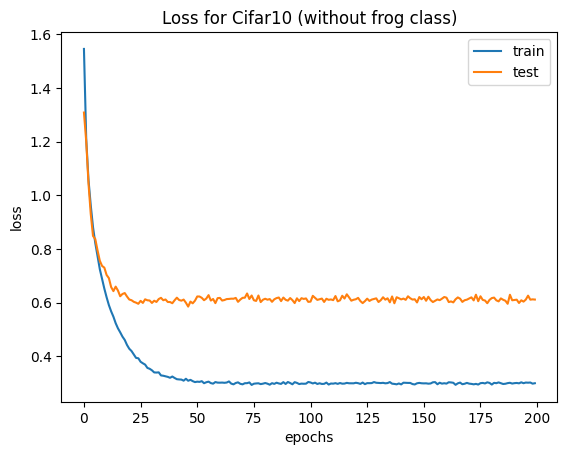

In [26]:
plot_curves([loss_train1, loss_val1], title = "Loss for Cifar10 (without frog class)")

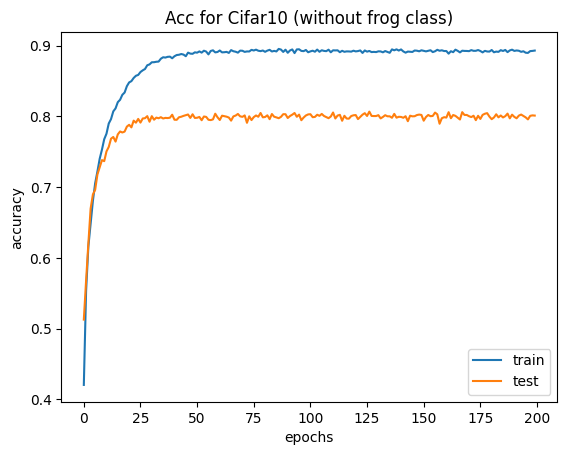

In [33]:
plot_curves([acc_train1, acc_val1], title = "Acc for Cifar10 (without frog class)", y_lab = "accuracy")

In [144]:
def find_threshold(threshold):
    for t in threshold:

        total_sum = 0
        for i ,(inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            logits = model1(inputs)
            softmax = nn.Softmax(dim=1)
            probs = softmax(logits).cpu()
            sum_in = (probs.max(dim=1).values > t).sum()
            total_sum+=sum_in 
        percent = total_sum/len(filtered_dataset_test_forg)
        if percent >= 0.95:
            #final_threshold = t
            break;
    return t
        

In [145]:
thresholds = []
for i in range(80, 200, 10):
    thresholds.append(i*0.5/100)
rev_thresholds = list(reversed(thresholds))

In [146]:
threshold = find_threshold(rev_thresholds)
print("accepted threshod for frogs is:", threshold)

accepted threshod for frogs is: 0.45


In [147]:
def outlier(threshold):
    total_sum = 0
    for inputs, labels in test_loader_frog:
        inputs = inputs.to(device)
        labels = labels.to(device)
        logits = model1(inputs)
        softmax = nn.Softmax(dim=1)
        probs = softmax(logits).cpu()
        sum_in = (probs.max(dim=1).values > threshold).sum()
        total_sum+=sum_in
    return (total_sum/len(dataset_test_frog))

In [148]:
test_loader_frog = DataLoader(dataset_test_frog,
                        batch_size = batch_size,
                        shuffle = False,
                        num_workers = 4)

In [149]:
inlier_percent = outlier(0.5)
print("for frog class %f perceent of datapoint are inliers" %inlier_percent)

for frog class 0.865000 perceent of datapoint are inliers


# PartB

In [ ]:
#cat  = 3

In [151]:
filtered_dataset_train_cat = FilteredDataset(dataset_train, [3]) # 3 == frog class
filtered_dataset_val_cat   = FilteredDataset(dataset_val, [3])
filtered_dataset_test_cat  = FilteredDataset(dataset_test, [3])

In [156]:
dataset_test_cat = FilteredDataset(dataset_test, [1,2,4,5,6,7,8,9])

In [157]:
train_loader_filtered_cat = DataLoader(filtered_dataset_train_cat,
                          batch_size = batch_size,
                          shuffle = True,
                          num_workers = 4)
val_loader_filtered_cat = DataLoader(filtered_dataset_val_cat,
                        batch_size = batch_size,
                        shuffle = False,
                        num_workers = 4)
test_loader_filtered_cat = DataLoader(filtered_dataset_test_cat,
                        batch_size = batch_size,
                        shuffle = False,
                        num_workers = 4)

In [158]:
model2 = ResNet18(3,10, False)
model2.to(device)

ResNet18(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [159]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model2.parameters(), lr=LEARNING_RATE, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9, verbose=True)
epochs = 200
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)

Adjusting learning rate of group 0 to 5.0000e-04.


In [160]:
model2, loss_train2, loss_val2, acc_train2, acc_val2 = train(model2, train_loader_filtered_cat, val_loader_filtered_cat)

  0%|          | 0/141 [00:00<?, ?it/s]

 epoch1: train_loss-> 1.474319554455115, val_loss-> 1.2388193734148716, train accuracy -> 0.4547069271758437, val_accuracy -> 0.5437056739279564
Adjusting learning rate of group 0 to 4.5000e-04.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch2: train_loss-> 1.1277906191708986, val_loss-> 1.07233483106532, train accuracy -> 0.5915297513321492, val_accuracy -> 0.6181072694190005
Adjusting learning rate of group 0 to 4.0500e-04.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch3: train_loss-> 0.9714254112269061, val_loss-> 1.0333984692891438, train accuracy -> 0.6515319715808171, val_accuracy -> 0.6347517730496454
Adjusting learning rate of group 0 to 3.6450e-04.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch4: train_loss-> 0.8711603994267872, val_loss-> 1.0005584042123024, train accuracy -> 0.6918572380106572, val_accuracy -> 0.6553856383824179
Adjusting learning rate of group 0 to 3.2805e-04.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch5: train_loss-> 0.7928167458749368, val_loss-> 0.7898684230679316, train accuracy -> 0.7213032859680284, val_accuracy -> 0.7208998228641267
Adjusting learning rate of group 0 to 2.9525e-04.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch6: train_loss-> 0.730923240604028, val_loss-> 0.7103675952617158, train accuracy -> 0.7435890319715808, val_accuracy -> 0.754565602921425
Adjusting learning rate of group 0 to 2.6572e-04.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch7: train_loss-> 0.6780739684405589, val_loss-> 0.7043207928221277, train accuracy -> 0.7651809502664298, val_accuracy -> 0.7531471632896586
Adjusting learning rate of group 0 to 2.3915e-04.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch8: train_loss-> 0.6318263425814322, val_loss-> 0.6926026154071727, train accuracy -> 0.7764209591474245, val_accuracy -> 0.7605718086797295
Adjusting learning rate of group 0 to 2.1523e-04.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch9: train_loss-> 0.5967428106186021, val_loss-> 0.6665061141582246, train accuracy -> 0.7941551953818827, val_accuracy -> 0.768395390070922
Adjusting learning rate of group 0 to 1.9371e-04.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch10: train_loss-> 0.5652060891711691, val_loss-> 0.6214036218663479, train accuracy -> 0.8037300177619894, val_accuracy -> 0.7892952125968663
Adjusting learning rate of group 0 to 1.7434e-04.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch11: train_loss-> 0.5292993683374585, val_loss-> 0.6086496636799886, train accuracy -> 0.8144982238010657, val_accuracy -> 0.7910682622422563
Adjusting learning rate of group 0 to 1.5691e-04.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch12: train_loss-> 0.5031115110454085, val_loss-> 0.5909586977874134, train accuracy -> 0.8231571936056838, val_accuracy -> 0.8007978725095167
Adjusting learning rate of group 0 to 1.4121e-04.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch13: train_loss-> 0.4861912815492488, val_loss-> 0.5708038139005079, train accuracy -> 0.8302064831261101, val_accuracy -> 0.8047872342116443
Adjusting learning rate of group 0 to 1.2709e-04.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch14: train_loss-> 0.4594571730965619, val_loss-> 0.5626917711809172, train accuracy -> 0.8389764653641207, val_accuracy -> 0.8098182623268019
Adjusting learning rate of group 0 to 1.1438e-04.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch15: train_loss-> 0.43984489074079436, val_loss-> 0.5697922135921235, train accuracy -> 0.8466640763765542, val_accuracy -> 0.8075354610774534
Adjusting learning rate of group 0 to 1.0295e-04.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch16: train_loss-> 0.4337881427410441, val_loss-> 0.5460986292108576, train accuracy -> 0.847857460035524, val_accuracy -> 0.8167996453055253
Adjusting learning rate of group 0 to 9.2651e-05.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch17: train_loss-> 0.40144084605717534, val_loss-> 0.5262475176483181, train accuracy -> 0.8589031971580817, val_accuracy -> 0.8201684398008576
Adjusting learning rate of group 0 to 8.3386e-05.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch18: train_loss-> 0.39011496244590615, val_loss-> 0.5295709963385941, train accuracy -> 0.8622058170515098, val_accuracy -> 0.8173758865248227
Adjusting learning rate of group 0 to 7.5047e-05.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch19: train_loss-> 0.37805574693010713, val_loss-> 0.5488145163295962, train accuracy -> 0.8672846358792184, val_accuracy -> 0.8141400708374402
Adjusting learning rate of group 0 to 6.7543e-05.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch20: train_loss-> 0.36591858934233923, val_loss-> 0.5268160252706379, train accuracy -> 0.8719471580817052, val_accuracy -> 0.8218528370485239
Adjusting learning rate of group 0 to 6.0788e-05.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch21: train_loss-> 0.352105423662527, val_loss-> 0.5253468755077808, train accuracy -> 0.877053730017762, val_accuracy -> 0.8254875887370279
Adjusting learning rate of group 0 to 5.4709e-05.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch22: train_loss-> 0.33933836258749345, val_loss-> 0.5157208267255877, train accuracy -> 0.8809391651865008, val_accuracy -> 0.8269725175614052
Adjusting learning rate of group 0 to 4.9239e-05.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch23: train_loss-> 0.33329116640410666, val_loss-> 0.5120243571751507, train accuracy -> 0.8814942273534636, val_accuracy -> 0.8291445036306448
Adjusting learning rate of group 0 to 4.4315e-05.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch24: train_loss-> 0.3245603349688422, val_loss-> 0.5127386156971573, train accuracy -> 0.8877941829484902, val_accuracy -> 0.8283466312056738
Adjusting learning rate of group 0 to 3.9883e-05.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch25: train_loss-> 0.31631921649932015, val_loss-> 0.5330318713441808, train accuracy -> 0.8887100355239786, val_accuracy -> 0.8268173759710704
Adjusting learning rate of group 0 to 3.5895e-05.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch26: train_loss-> 0.31315577983009246, val_loss-> 0.5129204832070263, train accuracy -> 0.8890430728241563, val_accuracy -> 0.8298315604527792
Adjusting learning rate of group 0 to 3.2305e-05.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch27: train_loss-> 0.30177925210810047, val_loss-> 0.511305608013843, train accuracy -> 0.8948989786856127, val_accuracy -> 0.8279920211920502
Adjusting learning rate of group 0 to 2.9075e-05.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch28: train_loss-> 0.2961044655864658, val_loss-> 0.5112849201293702, train accuracy -> 0.8951765097690941, val_accuracy -> 0.831826241303843
Adjusting learning rate of group 0 to 2.6167e-05.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch29: train_loss-> 0.29626071216211014, val_loss-> 0.5081056016134032, train accuracy -> 0.8956483126110124, val_accuracy -> 0.8307845744680851
Adjusting learning rate of group 0 to 2.3551e-05.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch30: train_loss-> 0.2877928560755181, val_loss-> 0.5070055333223749, train accuracy -> 0.8992284635879219, val_accuracy -> 0.833643616936731
Adjusting learning rate of group 0 to 2.1196e-05.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch31: train_loss-> 0.282093102340694, val_loss-> 0.5134683935143424, train accuracy -> 0.9012266873889876, val_accuracy -> 0.8331560285378855
Adjusting learning rate of group 0 to 1.9076e-05.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch32: train_loss-> 0.27045602405685304, val_loss-> 0.5107224386000464, train accuracy -> 0.9052786412078153, val_accuracy -> 0.838187056653043
Adjusting learning rate of group 0 to 1.7168e-05.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch33: train_loss-> 0.2710432865876923, val_loss-> 0.5043108002513859, train accuracy -> 0.9053896536412078, val_accuracy -> 0.8349512409656605
Adjusting learning rate of group 0 to 1.5452e-05.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch34: train_loss-> 0.26717328228599013, val_loss-> 0.5092041526280396, train accuracy -> 0.9056949378330373, val_accuracy -> 0.834552304964539
Adjusting learning rate of group 0 to 1.3906e-05.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch35: train_loss-> 0.2640147714695329, val_loss-> 0.5040381206265578, train accuracy -> 0.908303730017762, val_accuracy -> 0.8380319150627082
Adjusting learning rate of group 0 to 1.2516e-05.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch36: train_loss-> 0.2628770580194348, val_loss-> 0.5145774714067473, train accuracy -> 0.9076931616341031, val_accuracy -> 0.8383865246536039
Adjusting learning rate of group 0 to 1.1264e-05.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch37: train_loss-> 0.2577379032651866, val_loss-> 0.5100494542865889, train accuracy -> 0.9092195825932504, val_accuracy -> 0.8338652481424048
Adjusting learning rate of group 0 to 1.0138e-05.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch38: train_loss-> 0.2588514390386654, val_loss-> 0.5132725001015561, train accuracy -> 0.9079706927175843, val_accuracy -> 0.8357934398008576
Adjusting learning rate of group 0 to 9.1240e-06.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch39: train_loss-> 0.25350887975514885, val_loss-> 0.5224212724054959, train accuracy -> 0.9111067939609236, val_accuracy -> 0.8341976949509154
Adjusting learning rate of group 0 to 8.2116e-06.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch40: train_loss-> 0.25508225100449095, val_loss-> 0.524031068733398, train accuracy -> 0.9105239786856127, val_accuracy -> 0.8339982269503546
Adjusting learning rate of group 0 to 7.3904e-06.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch41: train_loss-> 0.2515648451251628, val_loss-> 0.49922492645733746, train accuracy -> 0.9113288188277087, val_accuracy -> 0.8394060282842487
Adjusting learning rate of group 0 to 6.6514e-06.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch42: train_loss-> 0.2525303746055858, val_loss-> 0.5164650452475176, train accuracy -> 0.9126054618117229, val_accuracy -> 0.839228723488801
Adjusting learning rate of group 0 to 5.9863e-06.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch43: train_loss-> 0.254247963812275, val_loss-> 0.5064488314356365, train accuracy -> 0.9096358792184724, val_accuracy -> 0.8357712765957447
Adjusting learning rate of group 0 to 5.3876e-06.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch44: train_loss-> 0.24798510340083768, val_loss-> 0.5164836955831406, train accuracy -> 0.9132715364120781, val_accuracy -> 0.8368794326241135
Adjusting learning rate of group 0 to 4.8489e-06.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch45: train_loss-> 0.2496087645208645, val_loss-> 0.5127535299629185, train accuracy -> 0.9126332149200711, val_accuracy -> 0.841954787149497
Adjusting learning rate of group 0 to 4.3640e-06.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch46: train_loss-> 0.24635205288181083, val_loss-> 0.5227193401214925, train accuracy -> 0.9132715364120781, val_accuracy -> 0.8327570921140359
Adjusting learning rate of group 0 to 3.9276e-06.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch47: train_loss-> 0.2470907848559942, val_loss-> 0.5192742097250959, train accuracy -> 0.9131327708703375, val_accuracy -> 0.8352171985815603
Adjusting learning rate of group 0 to 3.5348e-06.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch48: train_loss-> 0.24347825881695875, val_loss-> 0.519646241415477, train accuracy -> 0.9137155861456483, val_accuracy -> 0.8338652481424048
Adjusting learning rate of group 0 to 3.1813e-06.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch49: train_loss-> 0.24621891958199005, val_loss-> 0.5216906631880618, train accuracy -> 0.9134935612788633, val_accuracy -> 0.8374999998309088
Adjusting learning rate of group 0 to 2.8632e-06.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch50: train_loss-> 0.24005597235624998, val_loss-> 0.5163347096519267, train accuracy -> 0.9176010213143873, val_accuracy -> 0.838253546268382
Adjusting learning rate of group 0 to 2.5769e-06.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch51: train_loss-> 0.2392220897186501, val_loss-> 0.5055724010399892, train accuracy -> 0.9150199822380106, val_accuracy -> 0.8412677303273627
Adjusting learning rate of group 0 to 2.3192e-06.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch52: train_loss-> 0.24347463030480576, val_loss-> 0.5027958921929623, train accuracy -> 0.9141318827708703, val_accuracy -> 0.8393617022967508
Adjusting learning rate of group 0 to 2.0873e-06.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch53: train_loss-> 0.23612205920406812, val_loss-> 0.5229271354404748, train accuracy -> 0.9170459591474245, val_accuracy -> 0.8352836877741712
Adjusting learning rate of group 0 to 1.8786e-06.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch54: train_loss-> 0.24034303670904564, val_loss-> 0.5199482280311855, train accuracy -> 0.9148257104795737, val_accuracy -> 0.8368129434315026
Adjusting learning rate of group 0 to 1.6907e-06.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch55: train_loss-> 0.24141884421794071, val_loss-> 0.5180537704880356, train accuracy -> 0.9154640319715808, val_accuracy -> 0.8365913122258288
Adjusting learning rate of group 0 to 1.5216e-06.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch56: train_loss-> 0.24555579584164688, val_loss-> 0.5125244896039896, train accuracy -> 0.9138543516873889, val_accuracy -> 0.8368572694190005
Adjusting learning rate of group 0 to 1.3695e-06.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch57: train_loss-> 0.23885968695419507, val_loss-> 0.5242334557763229, train accuracy -> 0.9151309946714032, val_accuracy -> 0.8383643618712189
Adjusting learning rate of group 0 to 1.2325e-06.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch58: train_loss-> 0.23724022226451133, val_loss-> 0.5173529394974945, train accuracy -> 0.916934946714032, val_accuracy -> 0.8388962766802903
Adjusting learning rate of group 0 to 1.1093e-06.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch59: train_loss-> 0.24203735538369597, val_loss-> 0.5277142681128589, train accuracy -> 0.914464920071048, val_accuracy -> 0.8331117021276596
Adjusting learning rate of group 0 to 9.9834e-07.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch60: train_loss-> 0.2384772572606855, val_loss-> 0.5074550721873629, train accuracy -> 0.9154362788632326, val_accuracy -> 0.838231383063269
Adjusting learning rate of group 0 to 8.9851e-07.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch61: train_loss-> 0.23500620747120723, val_loss-> 0.5190206341286923, train accuracy -> 0.9179063055062167, val_accuracy -> 0.8383421986661059
Adjusting learning rate of group 0 to 8.0865e-07.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch62: train_loss-> 0.23411418348021448, val_loss-> 0.5205856854399891, train accuracy -> 0.9170459591474245, val_accuracy -> 0.8369237590343395
Adjusting learning rate of group 0 to 7.2779e-07.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch63: train_loss-> 0.23757564747577026, val_loss-> 0.5211797025292477, train accuracy -> 0.9158803285968028, val_accuracy -> 0.8353058509792842
Adjusting learning rate of group 0 to 6.5501e-07.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch64: train_loss-> 0.23487139172309457, val_loss-> 0.5170182288749844, train accuracy -> 0.9173234902309059, val_accuracy -> 0.8337101065520699
Adjusting learning rate of group 0 to 5.8951e-07.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch65: train_loss-> 0.23408172941281993, val_loss-> 0.5321068096879527, train accuracy -> 0.9185446269982238, val_accuracy -> 0.8406249999154544
Adjusting learning rate of group 0 to 5.3056e-07.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch66: train_loss-> 0.23697863662777532, val_loss-> 0.5219369716678105, train accuracy -> 0.9158525754884547, val_accuracy -> 0.8357269501855188
Adjusting learning rate of group 0 to 4.7750e-07.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch67: train_loss-> 0.2378850611155029, val_loss-> 0.5240682089793767, train accuracy -> 0.9169626998223801, val_accuracy -> 0.8362588654173181
Adjusting learning rate of group 0 to 4.2975e-07.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch68: train_loss-> 0.23735992200209446, val_loss-> 0.5267986975451733, train accuracy -> 0.9157415630550622, val_accuracy -> 0.8367686170212766
Adjusting learning rate of group 0 to 3.8678e-07.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch69: train_loss-> 0.2373593190873495, val_loss-> 0.5211641233652196, train accuracy -> 0.9156305506216696, val_accuracy -> 0.8337322693344549
Adjusting learning rate of group 0 to 3.4810e-07.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch70: train_loss-> 0.2366522743993606, val_loss-> 0.5174616899684812, train accuracy -> 0.9159358348134992, val_accuracy -> 0.8397384750927593
Adjusting learning rate of group 0 to 3.1329e-07.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch71: train_loss-> 0.23785721178482525, val_loss-> 0.5023096384520226, train accuracy -> 0.9138821047957372, val_accuracy -> 0.8392952126814118
Adjusting learning rate of group 0 to 2.8196e-07.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch72: train_loss-> 0.23876618392778756, val_loss-> 0.5250321974885379, train accuracy -> 0.9163798845470693, val_accuracy -> 0.8370789006246743
Adjusting learning rate of group 0 to 2.5376e-07.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch73: train_loss-> 0.23525732573035768, val_loss-> 0.5238999116716655, train accuracy -> 0.9166851687388987, val_accuracy -> 0.840026595913772
Adjusting learning rate of group 0 to 2.2839e-07.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch74: train_loss-> 0.23582628745168818, val_loss-> 0.5237491005067284, train accuracy -> 0.9152420071047958, val_accuracy -> 0.8337765957446809
Adjusting learning rate of group 0 to 2.0555e-07.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch75: train_loss-> 0.23228813154659306, val_loss-> 0.5172997817714163, train accuracy -> 0.9179895648312612, val_accuracy -> 0.8384751774740558
Adjusting learning rate of group 0 to 1.8499e-07.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch76: train_loss-> 0.23777215544061592, val_loss-> 0.5123586310139785, train accuracy -> 0.9157693161634103, val_accuracy -> 0.839228723488801
Adjusting learning rate of group 0 to 1.6649e-07.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch77: train_loss-> 0.23899780952274058, val_loss-> 0.5154360866715723, train accuracy -> 0.9151032415630551, val_accuracy -> 0.8421542551500577
Adjusting learning rate of group 0 to 1.4985e-07.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch78: train_loss-> 0.23447802034248044, val_loss-> 0.5240235932118503, train accuracy -> 0.9181005772646537, val_accuracy -> 0.837300531830348
Adjusting learning rate of group 0 to 1.3486e-07.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch79: train_loss-> 0.2353290731011233, val_loss-> 0.517929419135371, train accuracy -> 0.9166296625222025, val_accuracy -> 0.8334219857310572
Adjusting learning rate of group 0 to 1.2137e-07.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch80: train_loss-> 0.24023295601508968, val_loss-> 0.5200580855210623, train accuracy -> 0.9171292184724689, val_accuracy -> 0.8367907802263895
Adjusting learning rate of group 0 to 1.0924e-07.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch81: train_loss-> 0.23170104028647154, val_loss-> 0.5075406985925445, train accuracy -> 0.9190719360568383, val_accuracy -> 0.8411790779296388
Adjusting learning rate of group 0 to 9.8314e-08.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch82: train_loss-> 0.23572433409057755, val_loss-> 0.5190810656293909, train accuracy -> 0.9161856127886323, val_accuracy -> 0.8357934398008576
Adjusting learning rate of group 0 to 8.8482e-08.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch83: train_loss-> 0.23457999119856007, val_loss-> 0.5250989751401522, train accuracy -> 0.9174345026642984, val_accuracy -> 0.8383200354609929
Adjusting learning rate of group 0 to 7.9634e-08.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch84: train_loss-> 0.24006677126482157, val_loss-> 0.5138326369701548, train accuracy -> 0.9147146980461812, val_accuracy -> 0.8412455675449777
Adjusting learning rate of group 0 to 7.1671e-08.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch85: train_loss-> 0.23918206693329988, val_loss-> 0.5223700242473724, train accuracy -> 0.9146869449378331, val_accuracy -> 0.8396941491052614
Adjusting learning rate of group 0 to 6.4504e-08.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch86: train_loss-> 0.23676070642407793, val_loss-> 0.5148648991652415, train accuracy -> 0.9158525754884547, val_accuracy -> 0.8370124114320633
Adjusting learning rate of group 0 to 5.8053e-08.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch87: train_loss-> 0.2344158032038919, val_loss-> 0.5173409267308864, train accuracy -> 0.9181283303730018, val_accuracy -> 0.8419991135597229
Adjusting learning rate of group 0 to 5.2248e-08.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch88: train_loss-> 0.23705174629022344, val_loss-> 0.513153168537938, train accuracy -> 0.9162966252220248, val_accuracy -> 0.8402039007092199
Adjusting learning rate of group 0 to 4.7023e-08.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch89: train_loss-> 0.23426138291376947, val_loss-> 0.5223379283086628, train accuracy -> 0.9156860568383659, val_accuracy -> 0.8341090425531915
Adjusting learning rate of group 0 to 4.2321e-08.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch90: train_loss-> 0.23638378184282124, val_loss-> 0.5174103873841306, train accuracy -> 0.9176565275310835, val_accuracy -> 0.8318927304964538
Adjusting learning rate of group 0 to 3.8089e-08.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch91: train_loss-> 0.23459429512227195, val_loss-> 0.5000630232459264, train accuracy -> 0.9184613676731794, val_accuracy -> 0.8404033687097806
Adjusting learning rate of group 0 to 3.4280e-08.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch92: train_loss-> 0.2350876012661529, val_loss-> 0.5296354716551219, train accuracy -> 0.9167129218472468, val_accuracy -> 0.8361480498144812
Adjusting learning rate of group 0 to 3.0852e-08.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch93: train_loss-> 0.23359559230228513, val_loss-> 0.5381113229491187, train accuracy -> 0.9166019094138543, val_accuracy -> 0.8340425533605805
Adjusting learning rate of group 0 to 2.7767e-08.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch94: train_loss-> 0.23630380225541536, val_loss-> 0.5164111112871914, train accuracy -> 0.9166296625222025, val_accuracy -> 0.8350177305809995
Adjusting learning rate of group 0 to 2.4990e-08.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch95: train_loss-> 0.23731131261449512, val_loss-> 0.5197568421668195, train accuracy -> 0.9176565275310835, val_accuracy -> 0.8383643618712189
Adjusting learning rate of group 0 to 2.2491e-08.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch96: train_loss-> 0.23737029409694418, val_loss-> 0.5085022828891768, train accuracy -> 0.9158803285968028, val_accuracy -> 0.8385195034615537
Adjusting learning rate of group 0 to 2.0242e-08.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch97: train_loss-> 0.23444169187392266, val_loss-> 0.5237445765775992, train accuracy -> 0.9178785523978685, val_accuracy -> 0.8375443262411347
Adjusting learning rate of group 0 to 1.8218e-08.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch98: train_loss-> 0.23767617375955488, val_loss-> 0.5243029612387325, train accuracy -> 0.9161578596802842, val_accuracy -> 0.8326019505237011
Adjusting learning rate of group 0 to 1.6396e-08.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch99: train_loss-> 0.23303598733900072, val_loss-> 0.5188480059728555, train accuracy -> 0.916934946714032, val_accuracy -> 0.8376994682541976
Adjusting learning rate of group 0 to 1.4756e-08.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch100: train_loss-> 0.23513351216726996, val_loss-> 0.5134914964437485, train accuracy -> 0.9164908969804618, val_accuracy -> 0.8388962766802903
Adjusting learning rate of group 0 to 1.3281e-08.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch101: train_loss-> 0.2367122606911943, val_loss-> 0.5183617918626636, train accuracy -> 0.9153530195381883, val_accuracy -> 0.8340203901554676
Adjusting learning rate of group 0 to 1.1953e-08.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch102: train_loss-> 0.2363106356950255, val_loss-> 0.5267253953514369, train accuracy -> 0.9183503552397868, val_accuracy -> 0.8320700352919017
Adjusting learning rate of group 0 to 1.0757e-08.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch103: train_loss-> 0.2337772421155052, val_loss-> 0.5167480746270917, train accuracy -> 0.9169904529307282, val_accuracy -> 0.8404255319148937
Adjusting learning rate of group 0 to 9.6816e-09.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch104: train_loss-> 0.23916796728518674, val_loss-> 0.5073827368781921, train accuracy -> 0.9162966252220248, val_accuracy -> 0.8422207447653967
Adjusting learning rate of group 0 to 8.7135e-09.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch105: train_loss-> 0.23351398555704161, val_loss-> 0.5162496879591164, train accuracy -> 0.9184891207815276, val_accuracy -> 0.8401374115166089
Adjusting learning rate of group 0 to 7.8421e-09.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch106: train_loss-> 0.2341866479594373, val_loss-> 0.5173101317375264, train accuracy -> 0.9170459591474245, val_accuracy -> 0.8370789006246743
Adjusting learning rate of group 0 to 7.0579e-09.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch107: train_loss-> 0.2369411020253522, val_loss-> 0.5115756000927154, train accuracy -> 0.9183226021314387, val_accuracy -> 0.8399157803109352
Adjusting learning rate of group 0 to 6.3521e-09.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch108: train_loss-> 0.23306298090498995, val_loss-> 0.5221432345978757, train accuracy -> 0.9177952930728241, val_accuracy -> 0.8404920211075045
Adjusting learning rate of group 0 to 5.7169e-09.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch109: train_loss-> 0.24207827225195155, val_loss-> 0.5239320899366487, train accuracy -> 0.9147979573712256, val_accuracy -> 0.8363031914048161
Adjusting learning rate of group 0 to 5.1452e-09.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch110: train_loss-> 0.23484763581153553, val_loss-> 0.510461966302378, train accuracy -> 0.9177397868561279, val_accuracy -> 0.8359707445963055
Adjusting learning rate of group 0 to 4.6307e-09.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch111: train_loss-> 0.23146044154573714, val_loss-> 0.5248219437421636, train accuracy -> 0.9186833925399644, val_accuracy -> 0.8367464538161636
Adjusting learning rate of group 0 to 4.1676e-09.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch112: train_loss-> 0.23870867713756502, val_loss-> 0.5123336084768282, train accuracy -> 0.9170459591474245, val_accuracy -> 0.842796985984694
Adjusting learning rate of group 0 to 3.7509e-09.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch113: train_loss-> 0.2339136939674457, val_loss-> 0.527593066294988, train accuracy -> 0.9187388987566607, val_accuracy -> 0.8367686170212766
Adjusting learning rate of group 0 to 3.3758e-09.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch114: train_loss-> 0.23320242081029377, val_loss-> 0.5162026540818789, train accuracy -> 0.9181005772646537, val_accuracy -> 0.8401817375041069
Adjusting learning rate of group 0 to 3.0382e-09.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch115: train_loss-> 0.2390963984107463, val_loss-> 0.5303975766432201, train accuracy -> 0.9144094138543517, val_accuracy -> 0.8333554965384463
Adjusting learning rate of group 0 to 2.7344e-09.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch116: train_loss-> 0.23795195875381703, val_loss-> 0.5043575513236066, train accuracy -> 0.9177952930728241, val_accuracy -> 0.8395168438870856
Adjusting learning rate of group 0 to 2.4609e-09.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch117: train_loss-> 0.235633937493099, val_loss-> 0.5080009947220484, train accuracy -> 0.9152142539964476, val_accuracy -> 0.8381427306655451
Adjusting learning rate of group 0 to 2.2148e-09.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch118: train_loss-> 0.23275325247491868, val_loss-> 0.5300244787271987, train accuracy -> 0.9183226021314387, val_accuracy -> 0.8347960993753257
Adjusting learning rate of group 0 to 1.9934e-09.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch119: train_loss-> 0.23560048285110805, val_loss-> 0.5143158956833765, train accuracy -> 0.9159080817051509, val_accuracy -> 0.8387854610774534
Adjusting learning rate of group 0 to 1.7940e-09.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch120: train_loss-> 0.23440169983048845, val_loss-> 0.519532228615267, train accuracy -> 0.9167961811722913, val_accuracy -> 0.8358156030059706
Adjusting learning rate of group 0 to 1.6146e-09.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch121: train_loss-> 0.23384172307926215, val_loss-> 0.5200293448799891, train accuracy -> 0.9171292184724689, val_accuracy -> 0.8387411346672274
Adjusting learning rate of group 0 to 1.4532e-09.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch122: train_loss-> 0.23350269119809405, val_loss-> 0.5121479276435595, train accuracy -> 0.9179063055062167, val_accuracy -> 0.8406471631205674
Adjusting learning rate of group 0 to 1.3078e-09.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch123: train_loss-> 0.23766203667988361, val_loss-> 0.5131186344099383, train accuracy -> 0.9165464031971581, val_accuracy -> 0.8404476951200066
Adjusting learning rate of group 0 to 1.1771e-09.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch124: train_loss-> 0.23760491519584115, val_loss-> 0.5247706271021079, train accuracy -> 0.9171847246891652, val_accuracy -> 0.8326019505237011
Adjusting learning rate of group 0 to 1.0594e-09.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch125: train_loss-> 0.23255579722764014, val_loss-> 0.5096067459659374, train accuracy -> 0.9179340586145648, val_accuracy -> 0.8370345746371763
Adjusting learning rate of group 0 to 9.5342e-10.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch126: train_loss-> 0.2381264467857659, val_loss-> 0.5195810039204063, train accuracy -> 0.9157693161634103, val_accuracy -> 0.836414007007653
Adjusting learning rate of group 0 to 8.5808e-10.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch127: train_loss-> 0.23834777104653432, val_loss-> 0.5204365594801328, train accuracy -> 0.9153807726465364, val_accuracy -> 0.8381648934479301
Adjusting learning rate of group 0 to 7.7227e-10.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch128: train_loss-> 0.23997576595623157, val_loss-> 0.511315755070524, train accuracy -> 0.9156860568383659, val_accuracy -> 0.8381427306655451
Adjusting learning rate of group 0 to 6.9504e-10.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch129: train_loss-> 0.23529844670879058, val_loss-> 0.5306180257957878, train accuracy -> 0.9167129218472468, val_accuracy -> 0.8356382977877949
Adjusting learning rate of group 0 to 6.2554e-10.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch130: train_loss-> 0.23502406188771527, val_loss-> 0.5135357773050349, train accuracy -> 0.9188221580817052, val_accuracy -> 0.8385195034615537
Adjusting learning rate of group 0 to 5.6298e-10.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch131: train_loss-> 0.23464062836411578, val_loss-> 0.5134216130625272, train accuracy -> 0.9184058614564832, val_accuracy -> 0.8407358155182912
Adjusting learning rate of group 0 to 5.0669e-10.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch132: train_loss-> 0.235577464646281, val_loss-> 0.5303885400929349, train accuracy -> 0.9159358348134992, val_accuracy -> 0.8349734041707736
Adjusting learning rate of group 0 to 4.5602e-10.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch133: train_loss-> 0.23228910148514312, val_loss-> 0.5152218874464644, train accuracy -> 0.9185446269982238, val_accuracy -> 0.8422207447653967
Adjusting learning rate of group 0 to 4.1042e-10.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch134: train_loss-> 0.23889085834392645, val_loss-> 0.5101189175818829, train accuracy -> 0.9156027975133215, val_accuracy -> 0.8370567374195613
Adjusting learning rate of group 0 to 3.6937e-10.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch135: train_loss-> 0.23645054619117487, val_loss-> 0.5219810767799404, train accuracy -> 0.9175177619893428, val_accuracy -> 0.8350842197736105
Adjusting learning rate of group 0 to 3.3244e-10.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch136: train_loss-> 0.23261385928462283, val_loss-> 0.5289919477828006, train accuracy -> 0.918183836589698, val_accuracy -> 0.8369459218167244
Adjusting learning rate of group 0 to 2.9919e-10.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch137: train_loss-> 0.23879757780270722, val_loss-> 0.5167954051008461, train accuracy -> 0.9152697602131439, val_accuracy -> 0.839184397078575
Adjusting learning rate of group 0 to 2.6927e-10.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch138: train_loss-> 0.2351603672622999, val_loss-> 0.5182645884177364, train accuracy -> 0.9171292184724689, val_accuracy -> 0.8387411346672274
Adjusting learning rate of group 0 to 2.4235e-10.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch139: train_loss-> 0.23552377213646208, val_loss-> 0.5248406209210132, train accuracy -> 0.9177397868561279, val_accuracy -> 0.8399601062984331
Adjusting learning rate of group 0 to 2.1811e-10.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch140: train_loss-> 0.23605500968904308, val_loss-> 0.5149621388590928, train accuracy -> 0.9165741563055062, val_accuracy -> 0.8393617022967508
Adjusting learning rate of group 0 to 1.9630e-10.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch141: train_loss-> 0.2394923015661392, val_loss-> 0.5090763181025255, train accuracy -> 0.9171847246891652, val_accuracy -> 0.8385638298717797
Adjusting learning rate of group 0 to 1.7667e-10.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch142: train_loss-> 0.2332789593543295, val_loss-> 0.5130167427003807, train accuracy -> 0.9163521314387212, val_accuracy -> 0.8401595742989939
Adjusting learning rate of group 0 to 1.5900e-10.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch143: train_loss-> 0.2353926255610866, val_loss-> 0.510024941348015, train accuracy -> 0.9171847246891652, val_accuracy -> 0.8381205674604322
Adjusting learning rate of group 0 to 1.4310e-10.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch144: train_loss-> 0.23618053644895554, val_loss-> 0.5260019115311034, train accuracy -> 0.9168516873889876, val_accuracy -> 0.8377216310365826
Adjusting learning rate of group 0 to 1.2879e-10.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch145: train_loss-> 0.23442006032404425, val_loss-> 0.523731067882362, train accuracy -> 0.9172957371225577, val_accuracy -> 0.8340647161429655
Adjusting learning rate of group 0 to 1.1591e-10.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch146: train_loss-> 0.23832899125600582, val_loss-> 0.5275132479608482, train accuracy -> 0.9166851687388987, val_accuracy -> 0.8337544325395678
Adjusting learning rate of group 0 to 1.0432e-10.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch147: train_loss-> 0.23546105330780176, val_loss-> 0.5171650545605531, train accuracy -> 0.918183836589698, val_accuracy -> 0.8350177305809995
Adjusting learning rate of group 0 to 9.3890e-11.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch148: train_loss-> 0.23635973983161404, val_loss-> 0.518480696259661, train accuracy -> 0.9162966252220248, val_accuracy -> 0.8357934398008576
Adjusting learning rate of group 0 to 8.4501e-11.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch149: train_loss-> 0.23841455619828528, val_loss-> 0.5232075467600045, train accuracy -> 0.9175732682060391, val_accuracy -> 0.8368794326241135
Adjusting learning rate of group 0 to 7.6051e-11.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch150: train_loss-> 0.23363523035712183, val_loss-> 0.5170308568164812, train accuracy -> 0.9181283303730018, val_accuracy -> 0.8353058509792842
Adjusting learning rate of group 0 to 6.8446e-11.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch151: train_loss-> 0.2394163604051563, val_loss-> 0.5172741458559713, train accuracy -> 0.9155750444049734, val_accuracy -> 0.8370345746371763
Adjusting learning rate of group 0 to 6.1601e-11.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch152: train_loss-> 0.2338344720829126, val_loss-> 0.5043464007107079, train accuracy -> 0.9167684280639432, val_accuracy -> 0.8422872339580076
Adjusting learning rate of group 0 to 5.5441e-11.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch153: train_loss-> 0.23921084347086732, val_loss-> 0.5037187029283943, train accuracy -> 0.9145481793960923, val_accuracy -> 0.8396941491052614
Adjusting learning rate of group 0 to 4.9897e-11.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch154: train_loss-> 0.2337792844215464, val_loss-> 0.5189840156347194, train accuracy -> 0.9171569715808171, val_accuracy -> 0.8402925531069437
Adjusting learning rate of group 0 to 4.4907e-11.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch155: train_loss-> 0.23156219670552344, val_loss-> 0.5091628308625932, train accuracy -> 0.9167129218472468, val_accuracy -> 0.8368572694190005
Adjusting learning rate of group 0 to 4.0417e-11.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch156: train_loss-> 0.23606059212919134, val_loss-> 0.5258514606360848, train accuracy -> 0.9159358348134992, val_accuracy -> 0.8350842197736105
Adjusting learning rate of group 0 to 3.6375e-11.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch157: train_loss-> 0.237679685384935, val_loss-> 0.5069444091818857, train accuracy -> 0.9147424511545293, val_accuracy -> 0.8415780143534883
Adjusting learning rate of group 0 to 3.2737e-11.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch158: train_loss-> 0.23521195276645318, val_loss-> 0.5253875231277858, train accuracy -> 0.9162411190053286, val_accuracy -> 0.8342198581560284
Adjusting learning rate of group 0 to 2.9464e-11.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch159: train_loss-> 0.2344700324268049, val_loss-> 0.5160135138542095, train accuracy -> 0.9174622557726465, val_accuracy -> 0.8405141843126175
Adjusting learning rate of group 0 to 2.6517e-11.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch160: train_loss-> 0.23666849506102489, val_loss-> 0.5208175011137699, train accuracy -> 0.9165741563055062, val_accuracy -> 0.8370345746371763
Adjusting learning rate of group 0 to 2.3866e-11.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch161: train_loss-> 0.23336506343808944, val_loss-> 0.5139956878009417, train accuracy -> 0.9199045293072824, val_accuracy -> 0.8379654254473693
Adjusting learning rate of group 0 to 2.1479e-11.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch162: train_loss-> 0.23981166731559575, val_loss-> 0.5134680229932704, train accuracy -> 0.9159080817051509, val_accuracy -> 0.8392952126814118
Adjusting learning rate of group 0 to 1.9331e-11.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch163: train_loss-> 0.23699130695544804, val_loss-> 0.5164490273446901, train accuracy -> 0.9174900088809946, val_accuracy -> 0.835460992992347
Adjusting learning rate of group 0 to 1.7398e-11.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch164: train_loss-> 0.23356587287587763, val_loss-> 0.5074852963922717, train accuracy -> 0.9187944049733571, val_accuracy -> 0.8389627658729012
Adjusting learning rate of group 0 to 1.5658e-11.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch165: train_loss-> 0.23350922610498237, val_loss-> 0.5155063256727043, train accuracy -> 0.919404973357016, val_accuracy -> 0.834640957362263
Adjusting learning rate of group 0 to 1.4092e-11.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch166: train_loss-> 0.23379225613380622, val_loss-> 0.5102590348915006, train accuracy -> 0.9178785523978685, val_accuracy -> 0.8370124114320633
Adjusting learning rate of group 0 to 1.2683e-11.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch167: train_loss-> 0.2331079799635584, val_loss-> 0.5191730494934617, train accuracy -> 0.9188499111900533, val_accuracy -> 0.8398492906955962
Adjusting learning rate of group 0 to 1.1415e-11.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch168: train_loss-> 0.23757741694234405, val_loss-> 0.5199024973186195, train accuracy -> 0.9158248223801065, val_accuracy -> 0.8369015958292264
Adjusting learning rate of group 0 to 1.0273e-11.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch169: train_loss-> 0.23988312722364075, val_loss-> 0.5077783313203366, train accuracy -> 0.9151865008880995, val_accuracy -> 0.8412455675449777
Adjusting learning rate of group 0 to 9.2460e-12.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch170: train_loss-> 0.2354086834348434, val_loss-> 0.5115794187530558, train accuracy -> 0.9155472912966253, val_accuracy -> 0.8414450355455385
Adjusting learning rate of group 0 to 8.3214e-12.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch171: train_loss-> 0.23653921585523427, val_loss-> 0.5160788841915469, train accuracy -> 0.9174067495559503, val_accuracy -> 0.8386746454746166
Adjusting learning rate of group 0 to 7.4893e-12.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch172: train_loss-> 0.23485304234585797, val_loss-> 0.5180607145348339, train accuracy -> 0.9183503552397868, val_accuracy -> 0.8374556738434108
Adjusting learning rate of group 0 to 6.7403e-12.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch173: train_loss-> 0.2337989848418092, val_loss-> 0.5144675394110646, train accuracy -> 0.9171292184724689, val_accuracy -> 0.8395611702973116
Adjusting learning rate of group 0 to 6.0663e-12.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch174: train_loss-> 0.23574341707871185, val_loss-> 0.5109312321911467, train accuracy -> 0.91651865008881, val_accuracy -> 0.8413785459301996
Adjusting learning rate of group 0 to 5.4597e-12.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch175: train_loss-> 0.23675829049060865, val_loss-> 0.5211478503460579, train accuracy -> 0.9168239342806395, val_accuracy -> 0.8395168438870856
Adjusting learning rate of group 0 to 4.9137e-12.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch176: train_loss-> 0.23252585391327077, val_loss-> 0.5049305465204496, train accuracy -> 0.9175732682060391, val_accuracy -> 0.8369680850218374
Adjusting learning rate of group 0 to 4.4223e-12.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch177: train_loss-> 0.23712042426660684, val_loss-> 0.5238131069122477, train accuracy -> 0.9164631438721137, val_accuracy -> 0.8396498226950354
Adjusting learning rate of group 0 to 3.9801e-12.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch178: train_loss-> 0.23084180500378193, val_loss-> 0.5103106804139225, train accuracy -> 0.9181005772646537, val_accuracy -> 0.839228723488801
Adjusting learning rate of group 0 to 3.5821e-12.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch179: train_loss-> 0.23752001629973601, val_loss-> 0.5185675875726321, train accuracy -> 0.9166296625222025, val_accuracy -> 0.8378102838570345
Adjusting learning rate of group 0 to 3.2239e-12.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch180: train_loss-> 0.23732179464180134, val_loss-> 0.5263741971753167, train accuracy -> 0.9180450710479574, val_accuracy -> 0.8345301417594261
Adjusting learning rate of group 0 to 2.9015e-12.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch181: train_loss-> 0.23645667740363846, val_loss-> 0.51911849576108, train accuracy -> 0.9177952930728241, val_accuracy -> 0.8375886526513607
Adjusting learning rate of group 0 to 2.6113e-12.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch182: train_loss-> 0.23989327212210024, val_loss-> 0.5170303498599547, train accuracy -> 0.9154917850799289, val_accuracy -> 0.8348404253628237
Adjusting learning rate of group 0 to 2.3502e-12.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch183: train_loss-> 0.2340319402661459, val_loss-> 0.5299191192743626, train accuracy -> 0.9179340586145648, val_accuracy -> 0.8370567374195613
Adjusting learning rate of group 0 to 2.1152e-12.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch184: train_loss-> 0.23247808380776994, val_loss-> 0.5171154386608313, train accuracy -> 0.9192939609236235, val_accuracy -> 0.8365913122258288
Adjusting learning rate of group 0 to 1.9037e-12.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch185: train_loss-> 0.23836295474750746, val_loss-> 0.5176740253859378, train accuracy -> 0.9153252664298401, val_accuracy -> 0.8378767730496454
Adjusting learning rate of group 0 to 1.7133e-12.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch186: train_loss-> 0.23563769648966526, val_loss-> 0.5158251303624599, train accuracy -> 0.9163798845470693, val_accuracy -> 0.8410682623268019
Adjusting learning rate of group 0 to 1.5420e-12.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch187: train_loss-> 0.23860298617880255, val_loss-> 0.5145750746447989, train accuracy -> 0.9152420071047958, val_accuracy -> 0.8407358155182912
Adjusting learning rate of group 0 to 1.3878e-12.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch188: train_loss-> 0.23246862319815859, val_loss-> 0.5219150065107548, train accuracy -> 0.9176287744227354, val_accuracy -> 0.8379875886524822
Adjusting learning rate of group 0 to 1.2490e-12.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch189: train_loss-> 0.23603368312993864, val_loss-> 0.5277947935652225, train accuracy -> 0.9174900088809946, val_accuracy -> 0.836347517815042
Adjusting learning rate of group 0 to 1.1241e-12.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch190: train_loss-> 0.23910364607881696, val_loss-> 0.5104062180992559, train accuracy -> 0.9164076376554174, val_accuracy -> 0.8374113474331849
Adjusting learning rate of group 0 to 1.0117e-12.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch191: train_loss-> 0.23787091151673884, val_loss-> 0.5203853291822663, train accuracy -> 0.9163243783303731, val_accuracy -> 0.8359042554036945
Adjusting learning rate of group 0 to 9.1052e-13.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch192: train_loss-> 0.23800229188551064, val_loss-> 0.5183989901280572, train accuracy -> 0.9156860568383659, val_accuracy -> 0.8358377657883557
Adjusting learning rate of group 0 to 8.1947e-13.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch193: train_loss-> 0.23554612637942468, val_loss-> 0.5227334291165602, train accuracy -> 0.9182115896980462, val_accuracy -> 0.8370789006246743
Adjusting learning rate of group 0 to 7.3752e-13.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch194: train_loss-> 0.2380196233387527, val_loss-> 0.518288087865985, train accuracy -> 0.9155750444049734, val_accuracy -> 0.8379210994598714
Adjusting learning rate of group 0 to 6.6377e-13.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch195: train_loss-> 0.23702502940147852, val_loss-> 0.514037752722172, train accuracy -> 0.9165741563055062, val_accuracy -> 0.8396276594899225
Adjusting learning rate of group 0 to 5.9739e-13.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch196: train_loss-> 0.23509314759480593, val_loss-> 0.5226347660976098, train accuracy -> 0.9166574156305506, val_accuracy -> 0.8346852837724889
Adjusting learning rate of group 0 to 5.3765e-13.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch197: train_loss-> 0.23321759110551532, val_loss-> 0.5194767677614874, train accuracy -> 0.9170737122557726, val_accuracy -> 0.8366578014184397
Adjusting learning rate of group 0 to 4.8389e-13.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch198: train_loss-> 0.23887207975104902, val_loss-> 0.5277104987531689, train accuracy -> 0.9162688721136767, val_accuracy -> 0.8341755317458024
Adjusting learning rate of group 0 to 4.3550e-13.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch199: train_loss-> 0.2384658678439752, val_loss-> 0.5248139551345338, train accuracy -> 0.9157970692717584, val_accuracy -> 0.8348182625804387
Adjusting learning rate of group 0 to 3.9195e-13.


  0%|          | 0/141 [00:00<?, ?it/s]

 epoch200: train_loss-> 0.24001644848850862, val_loss-> 0.5249684340987645, train accuracy -> 0.9148534635879219, val_accuracy -> 0.839184397078575
Adjusting learning rate of group 0 to 3.5275e-13.


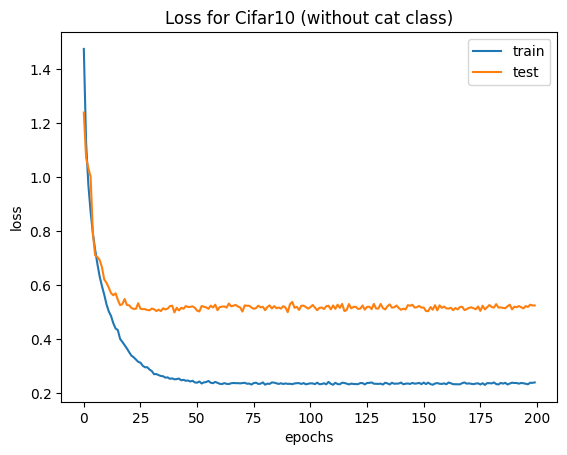

In [161]:
plot_curves([loss_train2, loss_val2], title = "Loss for Cifar10 (without cat class)")

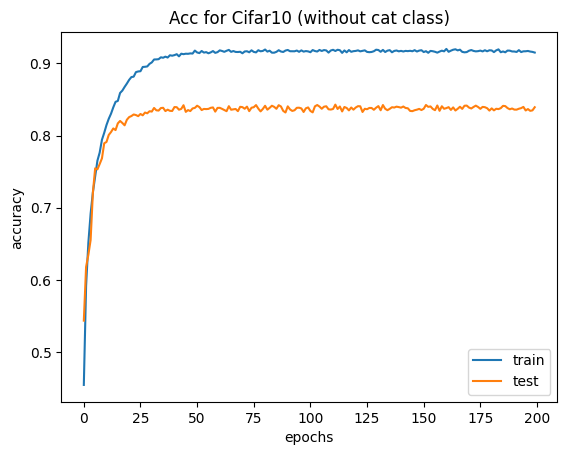

In [162]:
plot_curves([acc_train2, acc_val2], title = "Acc for Cifar10 (without cat class)", y_lab = "accuracy")

In [164]:
def find_threshold(threshold):
    for t in threshold:

        total_sum = 0
        for i ,(inputs, labels) in enumerate(test_loader_filtered_cat):
            inputs = inputs.to(device)
            labels = labels.to(device)
            logits = model1(inputs)
            softmax = nn.Softmax(dim=1)
            probs = softmax(logits).cpu()
            sum_in = (probs.max(dim=1).values > t).sum()
            total_sum+=sum_in 
        percent = total_sum/len(filtered_dataset_test_cat)
        if percent >= 0.95:
            #final_threshold = t
            break;
    return t

In [165]:
threshold = find_threshold(rev_thresholds)
print("accepted threshod for cats is:", threshold)

accepted threshod for cats is: 0.45


In [166]:
def outlier(threshold):
    total_sum = 0
    for inputs, labels in test_loader_cat:
        inputs = inputs.to(device)
        labels = labels.to(device)
        logits = model1(inputs)
        softmax = nn.Softmax(dim=1)
        probs = softmax(logits).cpu()
        sum_in = (probs.max(dim=1).values > threshold).sum()
        total_sum+=sum_in
    return (total_sum/len(dataset_test_cat))

In [167]:
test_loader_cat = DataLoader(dataset_test_cat,
                        batch_size = batch_size,
                        shuffle = False,
                        num_workers = 4)

In [168]:
inlier_percent = outlier(0.5)
print("for frog class %f perceent of datapoint are inliers" %inlier_percent)

for frog class 0.889500 perceent of datapoint are inliers
